# Maze Experiments in Curriculum Learning in a Single Environment
## Still the same principle, just saving memory
## Give the Reward To Teacher
-------------------------------


Salkey, Jayson

26/07/2018

-----------------------------------


# Setup

### Import Useful Libraries

In [196]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from collections import namedtuple
from scipy import stats

### Set options

In [197]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=1)

In [198]:
class Maze(object):
    def __init__(self, width, height, complexity, density, num_goals, goal):
        self._maze, self._maze_clean, self._goal_locations = self.maze(width, height, complexity, density, num_goals, goal)
        
    def maze(self, width=81, height=51, complexity=.75, density=.75, num_goals=1, goal=1):
        goal_locations = []
        
        # Only odd shapes
        shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
        # Adjust complexity and density relative to maze size
        complexity = int(complexity * (5 * (shape[0] + shape[1]))) # number of components
        density    = int(density * ((shape[0] // 2) * (shape[1] // 2))) # size of components
        # Build actual maze
        Z = np.zeros(shape)
        # Fill borders
        Z[0, :] = Z[-1, :] = 1
        Z[:, 0] = Z[:, -1] = 1
        # Make aisles
        for i in range(density):
            x, y = np.random.randint(0, (shape[1] // 2)+1) * 2, np.random.randint(0, (shape[0] // 2)+1) * 2 # pick a random position
            Z[y, x] = 1
            for j in range(complexity):
                neighbours = []
                if x > 1:             neighbours.append((y, x - 2))
                if x < shape[1] - 2:  neighbours.append((y, x + 2))
                if y > 1:             neighbours.append((y - 2, x))
                if y < shape[0] - 2:  neighbours.append((y + 2, x))
                if len(neighbours):
                    y_,x_ = neighbours[np.random.randint(0, len(neighbours))]
                    if Z[y_, x_] == 0:
                        Z[y_, x_] = 1
                        Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                        x, y = x_, y_
        Z[Z == 1] = -1
        Y = np.copy(Z)
        for x in range(0, num_goals):
            idx = np.random.randint(len(np.where(Z == 0)[0]))
            Z[np.where(Z == 0)[0][idx],np.where(Z == 0)[1][idx]] = goal
        for e in zip(np.where(Z == goal)[0],np.where(Z == goal)[1]):
            goal_locations.append((e[0],e[1],goal))
        return Z,Y,goal_locations


### A hallway world

In [199]:
class Hallway(object):

  def __init__(self, goal_loc, tabular=True, vision_size=1, discount=0.98, noisy=False, layout=None):
    
    self._wall = -1
    self._layout = layout
    
    # row, col format
    self._start_state = (1, 1)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy
    self._tabular = tabular
    self._vision_size = vision_size
    self._discount = discount
    
    self._goals = set()
    self._goal_loc = []
    self._distances_to_goal = []
    
    self._dist = {}
    for r,c in zip(np.where(self._layout != self._wall)[0],np.where(self._layout != self._wall)[1]):
      self._dist[(r, c)] = self.dijkstra(r, c)
      
    for e in goal_loc:
      self._layout[e[0],e[1]] = e[2]
      self._goal_loc.append((e[0],e[1]))
      self._goals.add(e[2])
      self._distances_to_goal.append(self.minDistanceTwoPoints(self._start_state[0], self._start_state[1], e[0],e[1]))
    
    
  def resetState(self):
    self._state = self._start_state
  
  def distanceLeft(self, teacher_action):
    goal_y = self._goal_loc[teacher_action][0]
    goal_x = self._goal_loc[teacher_action][1]
    return self.minDistanceTwoPoints(self._state[0], self._state[1], goal_y, goal_x)
  
  def distanceToGoal(self, teacher_action):
    return np.prod(self._layout.shape)
  
  def dijkstra(self, cy, cx):
    dist = {}
    prev = {}
    Q = set()
    
    for r,c in zip(np.where(self._layout != self._wall)[0],np.where(self._layout != self._wall)[1]):
      dist[(r,c)] = np.inf
      prev[(r,c)] = None
      Q.add((r,c))
    
    dist[(cy,cx)] = 0.
    
    while len(Q) != 0:
      ud = np.inf
      u = None
      for e in Q:
        if dist[e] < ud:
          ud = dist[e]
          u = e
      Q.remove(u)
      
      neighbors_u = []
      if u[0]+1 < self._layout.shape[0] and self._layout[u[0]+1, u[1]] != self._wall and (u[0]+1, u[1]) in Q:
        neighbors_u.append((u[0]+1, u[1]))
      
      if u[0]-1 > -1 and self._layout[u[0]-1, u[1]] != self._wall and (u[0]-1, u[1]) in Q:
        neighbors_u.append((u[0]-1, u[1]))
      
      if u[1]+1 < self._layout.shape[1] and self._layout[u[0], u[1]+1] != self._wall and (u[0], u[1]+1) in Q:
        neighbors_u.append((u[0], u[1]+1))
      
      if u[1]-1 > -1 and self._layout[u[0], u[1]-1] != self._wall and (u[0], u[1]-1) in Q:
        neighbors_u.append((u[0], u[1]-1))
        
      for neighbor in neighbors_u:
        alt = dist[u] + 1.
        if alt < dist[neighbor]:
          dist[neighbor] = alt
          prev[neighbor] = u
    
    return dist
  
  def minDistanceTwoPoints(self, cy, cx, dy, dx):
    return self._dist[(cy,cx)][(dy,dx)]
    
  def handleDoor(self):
    pass
  
  @property
  def number_of_states(self):
    return self._number_of_states
    
  def plot_grid(self, title=None):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != self._wall, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    if title != None:
      plt.title(title)
    else:
      plt.title("The Grid")
    plt.text(self._start_state[1], self._start_state[0], r"$\mathbf{S}$", ha='center', va='center')
    for e in self._goals:
      if e > 0:
        y = np.where(self._layout==e)[0]
        x = np.where(self._layout==e)[1]
        for i in range(y.shape[0]): 
          plt.text(x[i], y[i], r"$\mathbf{G}$", ha='center', va='center')  
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  def get_obs(self):
    y, x = self._state
    return self.get_obs_at(x, y)

  def get_obs_at(self, x, y):
    if self._tabular:
      return y*self._layout.shape[1] + x
    else:
      v = self._vision_size
      #location = np.clip(-self._layout[y-v:y+v+1,x-v:x+v+1], 0, 1)
      #location = np.clip(-self._layout[y-v:y+v+1,x-v:x+v+1], -1, 2)
      location = self._layout[y-v:y+v+1,x-v:x+v+1]
      return location

  def step(self, action, teacher_action, agent_inventory):
    item = None
    goal_y = self._goal_loc[teacher_action][0]
    goal_x = self._goal_loc[teacher_action][1]
    y, x = self._state
        
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    discount = self._discount
    if self._layout[new_y, new_x] == self._wall:  # a wall
      reward = -1
      new_state = (y, x)
    elif self._layout[new_y, new_x] > 0 and (new_y, new_x) == (goal_y, goal_x) : # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    else:
      #minDistanceStart = self.minDistanceTwoPoints(self._start_state[0], self._start_state[1], goal_y, goal_x)
      distToGoal = self.minDistanceTwoPoints(new_y, new_x, goal_y, goal_x)
      distToGoal = float(distToGoal)
      #minDistanceStart = float(minDistanceStart)
      reward = np.exp(-distToGoal) - 1.
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)
    
    self._state = new_state

    return reward, discount, self.get_obs(), item
     

### The Hallway(s)

('Task: 0', (1, 8, 1))
('Task: 1', (1, 18, 1))
('Task: 2', (7, 18, 1))
('Task: 3', (11, 16, 1))
('Task: 4', (16, 15, 1))


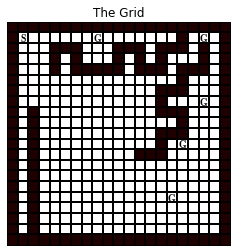

In [200]:
maze = Maze(20,20,0.1,0.05,5,1)  
vision_size = 1
tabular_grid = False

tasks = []
tasks.append(Hallway(goal_loc = maze._goal_locations, tabular=tabular_grid, vision_size=vision_size, discount=0.98, layout=np.copy(maze._maze_clean)))

for idx, goal_loc in enumerate(maze._goal_locations):
  print('Task: '+str(idx), goal_loc)

for task in tasks:
    task.plot_grid()


## Implement agents


In [201]:
class GeneralQ(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, target_policy, behaviour_policy, double, num_offline_updates=30, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
    self._replayBuffer_A = []
    if double:
      self._q2 = np.zeros((number_of_states, number_of_actions))
      self._replayBuffer_B = []
    self._s = initial_state
    self._initial_state = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._target_policy = target_policy
    self._double = double
    self._num_offline_updates = num_offline_updates
    self._last_action = 0
    self._inventory = set()
  
  def resetReplayBuffer(self):
    self._replayBuffer_A = []
    if self._double:
      self._replayBuffer_B = []
      
  @property
  def q_values(self):
    if self._double:
      return (self._q + self._q2)/2
    else:
      return self._q
    
  def resetState(self):
    self._s = self._initial_state 

  def step(self, r, g, s, item, train):
    td = None
    
    if item != None:
      self._inventory.add(item)
      
    if self._double:
      next_action = self._behaviour_policy(self.q_values[s,:], train)
      if np.random.random() <= 0.5:
        expectation = np.sum(self._target_policy(self._q[s,:], next_action) * self._q2[s,:])
        td = self._step_size*(r + g*expectation - self._q[self._s,self._last_action])
        if train == True:
          self._q[self._s,self._last_action] += self._step_size*(r + g*expectation - self._q[self._s,self._last_action])
          #self._q[self._s,self._last_action] += self._step_size*(r + g*self._q2[s,np.argmax(target_policy(self._q[s,:], next_action))] - self._q[self._s,self._last_action])
          self._replayBuffer_A.append([self._s,self._last_action,r,g,s,next_action])
          for _ in range(self._num_offline_updates):
            replay = self._replayBuffer_A[np.random.randint(len(self._replayBuffer_A))]
            expectation = np.sum(self._target_policy(self._q[replay[4],:], replay[5]) * self._q2[replay[4],:])
            self._q[replay[0],replay[1]] += self._step_size*(replay[2] + replay[3] * expectation - self._q[replay[0],replay[1]])

      else:
        expectation = np.sum(self._target_policy(self._q2[s,:], next_action) * self._q[s,:])
        td = self._step_size*(r + g*expectation - self._q2[self._s,self._last_action])
        if train == True:
          self._q2[self._s,self._last_action] += self._step_size*(r + g*expectation - self._q2[self._s,self._last_action])   
          #self._q2[self._s,self._last_action] += self._step_size*(r + g*self._q[s,np.argmax(target_policy(self._q2[s,:], next_action))] - self._q2[self._s,self._last_action])    
          self._replayBuffer_B.append([self._s,self._last_action,r,g,s,next_action])
          for _ in range(self._num_offline_updates):
            replay = self._replayBuffer_B[np.random.randint(len(self._replayBuffer_B))]
            expectation = np.sum(self._target_policy(self._q[replay[4],:], replay[5]) * self._q2[replay[4],:])
            self._q[replay[0],replay[1]] += self._step_size*(replay[2] + replay[3] * expectation - self._q[replay[0],replay[1]])

      self._s = s
      self._last_action = next_action
      return self._last_action, self._inventory, td
    else:
      next_action = self._behaviour_policy(self._q[s,:], train)
      # This is expected sarsa, but still functions as expected.
      expectation = np.sum(self._target_policy(self._q[s,:], next_action) * self._q[s,:])
      td = self._step_size*(r + g*expectation - self._q[self._s,self._last_action])
      if train == True:
        self._q[self._s,self._last_action] += self._step_size*(r + g*expectation - self._q[self._s,self._last_action])
        #self._q[self._s,self._last_action] += self._step_size*(r + g*self._q[s,np.argmax(target_policy(self._q[s,:], next_action))] - self._q[self._s,self._last_action])
        self._replayBuffer_A.append([self._s,self._last_action,r,g,s,next_action])
        for _ in range(self._num_offline_updates):
          replay = self._replayBuffer_A[np.random.randint(len(self._replayBuffer_A))]
          expectation = np.sum(self._target_policy(self._q[replay[4],:], replay[5]) * self._q2[replay[4],:])
          self._q[replay[0],replay[1]] += self._step_size*(replay[2] + replay[3] * expectation - self._q[replay[0],replay[1]])

      self._s = s
      self._last_action = next_action
      #print(self._inventory)
      return self._last_action, self._inventory, td
    

In [202]:
def Q_target_policy(q, a):
  return np.eye(len(q))[np.argmax(q)]

def SARSA_target_policy(q, a):
  return np.eye(len(q))[a]

def gen_behaviour_policy(q, train):
  #return epsilon_greedy(q, 0.1) if train == True else np.random.choice(np.where(np.max(q) == q)[0])
  return epsilon_greedy(q, 0.1) if train == True else epsilon_greedy(q, 0.01)

An agent that uses **Neural-Sarsa/DQN** to learn action values.  The agent should expect a nxn input which it should flatten into a vector, and then pass through a multi-layer perceptron with a single hidden layer with 100 hidden nodes and ReLU activations.  Each weight layer should also have a bias.  Initialize all weights uniformly randomly in $[-0.05, 0.05]$.

```
NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
            number_of_hidden=100,
            number_of_actions=4,
            initial_state=grid.get_obs(),
            step_size=0.01)
            
DQN(number_of_features=(2*vision_size + 1)**2,
            number_of_hidden=100,
            number_of_actions=4,
            initial_state=grid.get_obs(),
            step_size=0.01)
```

The number `vision_size` will be either 1 or 2 below.  The input vector will be of size $(2v + 1)^2$, which will correspond to a square local view of the grid, centered on the agent, and of size $(2v + 1) \times (2v + 1)$ (so either 3x3 or 5x5).

In [203]:
class NEURAL_CONTROLLER_DRIVER(object):
  
  # Target Network is the same, as C-step is just C=1
  
  def __init__(self, number_of_features_controller,
                number_of_features_driver,
                number_of_hidden_controller,
                number_of_hidden_driver,
                number_of_actions_controller,
                number_of_actions_driver,
                initial_state_controller,
                initial_state_driver, 
                rl_alg_controller='DQN',
                rl_alg_driver='DQN', 
                num_offline_updates_controller=25, 
                num_offline_updates_driver=25,
                step_size_controller=0.01,
                step_size_driver=0.01): 
    # HMMM?
    tf.reset_default_graph()

    self._prev_action_driver = 0
    self._step_driver = step_size_driver
    self._num_features_driver = number_of_features_driver
    self._num_action_driver = number_of_actions_driver
    self._num_hidden_driver = number_of_hidden_driver
    self._initial_state_driver = initial_state_driver
    self._s_driver = initial_state_driver
    self._s_driver = np.reshape(self._s_driver, (1,-1))
    self._times_trained_driver = 0
    self._inventory = set()
    self._replayBuffer_driver = []
    self._num_offline_updates_driver = num_offline_updates_driver
    self._rl_alg_driver = rl_alg_driver
    self._eps_driver = 1.0


    
    self._prev_action_controller = 0
    self._step_controller = step_size_controller
    self._num_features_controller = number_of_features_controller
    self._num_action_controller = number_of_actions_controller
    self._num_hidden_controller = number_of_hidden_controller
    self._initial_state_controller = initial_state_controller
    self._s_controller = initial_state_controller
    self._s_controller = np.reshape(self._s_controller, (1,-1))
    self._times_trained_controller = 0
    self._replayBuffer_controller = []
    self._num_offline_updates_controller = num_offline_updates_controller
    self._rl_alg_controller = rl_alg_controller
    self.name = 'HYPER '+self._rl_alg_controller
    self._eps_controller = 1.0
    
    # ?????????? should it be the number of tasks
    self._probs_controller = np.ones((1, self._num_features_controller))/(self._num_features_controller*1.)
    
    
    self._times_used = 0.
    
    self.handleTF()
  
  def reset(self):
    tf.reset_default_graph()
    self.handleTF()
    self.resetState_controller()
    self.resetReplayBuffer_controller()
    self._probs_controller = np.ones((1, self._num_features_controller))/(self._num_features_controller*1.)
    self._times_trained_controller = 0
    self._prev_action_controller = 0
    self._eps_controller = 1.0
    self.resetReplayBuffer()
    self.resetState()
    self._times_trained_driver = 0
    self._prev_action_driver = 0
    self._eps_driver = 1.0
    self._inventory = set()
    self._times_used = 0

  def resetReplayBuffer_controller(self):
    self._replayBuffer_controller = []
    
  def resetState_controller(self):
    self._s_controller = self._initial_state_controller 
    self._s_controller = np.reshape(self._s_controller, (1,-1))
    
  def handleTF(self):
    self._sess = tf.Session()
    #tf.reset_default_graph()
    self.rewTensor_controller = tf.placeholder(tf.float64)
    self.disTensor_controller = tf.placeholder(tf.float64)
    self.nqTensor_controller = tf.placeholder(tf.float64)
    self.actionTensor_controller = tf.placeholder(tf.int32)
    self.stateTensor_controller = tf.placeholder(tf.float64, shape=(1,self._num_features_controller))
    self._dense_1_controller = tf.layers.dense(self.stateTensor_controller,
                                    self._num_hidden_controller, activation=tf.nn.tanh,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._dense_2_controller = tf.layers.dense(self._dense_1_controller,
                                    self._num_action_controller, activation=None,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._q_controller = tf.reshape(self._dense_2_controller, (self._num_action_controller,))    
    self._softmx_controller = tf.nn.softmax(self._q_controller)
    self._cost_controller = tf.losses.mean_squared_error(self.rewTensor_controller + self.disTensor_controller*self.nqTensor_controller, self._q_controller[self.actionTensor_controller])
    self._opt_controller = tf.train.RMSPropOptimizer(self._step_controller).minimize(self._cost_controller) 
    

    self.rewTensor_driver = tf.placeholder(tf.float64)
    self.disTensor_driver = tf.placeholder(tf.float64)
    self.nqTensor_driver = tf.placeholder(tf.float64)
    self.actionTensor_driver = tf.placeholder(tf.int32)
    self.stateTensor_driver = tf.placeholder(tf.float64, shape=(1,self._num_features_driver))
    self._dense_1_driver = tf.layers.dense(self.stateTensor_driver,
                                    self._num_hidden_driver, activation=tf.nn.tanh,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._dense_2_driver = tf.layers.dense(self._dense_1_driver,
                                    self._num_action_driver, activation=None,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._q_driver = tf.reshape(self._dense_2_driver, (self._num_action_driver,))    
    self._cost_driver = tf.losses.mean_squared_error(self.rewTensor_driver+ self.disTensor_driver*self.nqTensor_driver, self._q_driver[self.actionTensor_driver])
    self._opt_driver = tf.train.RMSPropOptimizer(self._step_driver).minimize(self._cost_driver)


    # HMMM?
    self._sess.run(tf.global_variables_initializer())

  def _target_policy_controller(self, q, a):
    return np.eye(len(q))[a]
 
  def _behaviour_policy_controller(self, q):    
    return epsilon_greedy(q, self._eps_controller)# if train == True else np.random.choice(np.where(np.max(q) == q)[0])

  def getProbs(self):
    # softmax
    return self._probs_controller

  def q_controller(self, obs):
    #print [n.name for n in tf.get_default_graph().as_graph_def().node]
    obs = np.reshape(obs,(1,-1))
    #print obs
    t, probs = self._sess.run([self._q_controller, self._softmx_controller], {self.stateTensor_controller: obs})
    return t, probs
  
  def step_controller(self, r, g, s):
    self._times_used += 1
    #print self._times_used
    qvs, probs = self.q_controller(s)
    q_nxtState = np.reshape(qvs, (-1,))
    self._probs_controller = probs
    next_action = self._behaviour_policy_controller(q_nxtState)
    
    if r != None:
      if self._rl_alg_controller == 'NEURALSARSA':
        target = self._target_policy_controller(q_nxtState, next_action)
        target = np.random.choice(np.where(np.max(target) == target)[0])
        vob = q_nxtState[target]
        #print vob
        self._sess.run(self._opt_controller,{
            self.nqTensor_controller: vob,
            self.rewTensor_controller: r,
            self.disTensor_controller: g,
            self.actionTensor_controller: self._prev_action_controller,
            self.stateTensor_controller: self._s_controller})
        self._replayBuffer_controller.append([self._s_controller, self._prev_action_controller, r, g, vob])
        for _ in range(self._num_offline_updates_controller):
          replay = self._replayBuffer_controller[np.random.randint(len(self._replayBuffer_controller))]
          self._sess.run(self._opt_controller,{
              self.nqTensor_controller: replay[4],
              self.rewTensor_controller: replay[2],
              self.disTensor_controller: replay[3],
              self.actionTensor_controller: replay[1],
              self.stateTensor_controller: replay[0]})
      elif self._rl_alg_controller == 'DQN':
        # This function should return an action
        # Optimiser
        vob = np.max(q_nxtState)
        self._sess.run(self._opt_controller,{
            self.nqTensor_controller: vob,
            self.rewTensor_controller: r,
            self.disTensor_controller: g,
            self.actionTensor_controller: self._prev_action_controller,
            self.stateTensor_controller: self._s_controller})
        self._replayBuffer_controller.append([self._s_controller, self._prev_action_controller, r, g, vob])
        for _ in range(self._num_offline_updates_controller):
          replay = self._replayBuffer_controller[np.random.randint(len(self._replayBuffer_controller))]
          self._sess.run(self._opt_controller,{
              self.nqTensor_controller: replay[4],
              self.rewTensor_controller: replay[2],
              self.disTensor_controller: replay[3],
              self.actionTensor_controller: replay[1],
              self.stateTensor_controller: replay[0]})

    self._s_controller = np.reshape(s, (1,-1))
    self._prev_action_controller = next_action
    
    return next_action

  def reset_controller(self):
    tf.reset_default_graph()
    self.handleTF()
    self.resetState_controller()
    self.resetReplayBuffer_controller()
    self._probs_controller = np.ones((1, self._num_features_controller))/(self._num_features_controller*1.)
    self._times_trained_controller = 0
    self._prev_action_controller = 0



    # resetReplayBuffer_driver
  def resetReplayBuffer(self):
    self._replayBuffer_driver = []
    
    # resetState_driver
  def resetState(self):
    self._s_driver = self._initial_state_driver 
    self._s_driver = np.reshape(self._s_driver, (1,-1))


  def _target_policy_driver(self, q, a):
    return np.eye(len(q))[a]
 
  def _behaviour_policy_driver(self, q, train):
    #return epsilon_greedy(q, 0.1) if train == True else np.random.choice(np.where(np.max(q) == q)[0])
    return epsilon_greedy(q, self._eps_driver) if train == True else epsilon_greedy(q, 0.01)

  def q_driver(self, obs):
    #print [n.name for n in tf.get_default_graph().as_graph_def().node]
    obs = np.reshape(obs,(1,-1))
    #print obs
    t = self._sess.run(self._q_driver, {self.stateTensor_driver: obs})
    return t
  
  # step_driver
  def step(self, r, g, s, item, train, steps_taken):
    cost = None
    
    if item != None:
      self._inventory.add(item)
    
    # This function should return an action
    q_nxtState = np.reshape(self.q_driver(s), (-1,))
    next_action = self._behaviour_policy_driver(q_nxtState, train)
    

    if self._rl_alg_driver == 'NEURALSARSA':
      target = self._target_policy_driver(q_nxtState, next_action)
      target = np.random.choice(np.where(np.max(target) == target)[0])
      
      # Optimiser
      vob = q_nxtState[target]
#       cost = self._sess.run(self._cost_driver,{
#           self.nqTensor_driver: vob,
#           self.rewTensor_driver: r,
#           self.disTensor_driver: g,
#           self.actionTensor_driver: self._prev_action_driver,
#           self.stateTensor_driver: self._s_driver})
      if train == True:
        self._sess.run(self._opt_driver,{
            self.nqTensor_driver: vob,
            self.rewTensor_driver: r,
            self.disTensor_driver: g,
            self.actionTensor_driver: self._prev_action_driver,
            self.stateTensor_driver: self._s_driver})
        self._replayBuffer_driver.append([self._s_driver, self._prev_action_driver, r, g, vob])
        for _ in range(self._num_offline_updates_driver):
          replay = self._replayBuffer_driver[np.random.randint(len(self._replayBuffer_driver))]
          self._sess.run(self._opt_driver,{
              self.nqTensor_driver: replay[4],
              self.rewTensor_driver: replay[2],
              self.disTensor_driver: replay[3],
              self.actionTensor_driver: replay[1],
              self.stateTensor_driver: replay[0]})
    elif self._rl_alg_driver == 'DQN':
      vob = np.max(q_nxtState)
#       cost = self._sess.run(self._cost_driver,{
#               self.nqTensor_driver: vob,
#               self.rewTensor_driver: r,
#               self.disTensor_driver: g,
#               self.actionTensor_driver: self._prev_action_driver,
#               self.stateTensor_driver: self._s_driver})
      if train == True:
        self._sess.run(self._opt_driver,{
            self.nqTensor_driver: vob,
            self.rewTensor_driver: r,
            self.disTensor_driver: g,
            self.actionTensor_driver: self._prev_action_driver,
            self.stateTensor_driver: self._s_driver})
        self._replayBuffer_driver.append([self._s_driver, self._prev_action_driver, r, g, vob])
        for _ in range(self._num_offline_updates_driver):
          replay = self._replayBuffer_driver[np.random.randint(len(self._replayBuffer_driver))]
          self._sess.run(self._opt_driver,{
              self.nqTensor_driver: replay[4],
              self.rewTensor_driver: replay[2],
              self.disTensor_driver: replay[3],
              self.actionTensor_driver: replay[1],
              self.stateTensor_driver: replay[0]})

    
        
    self._s_driver = np.reshape(s, (1,-1))
    self._prev_action_driver = next_action
    return next_action, self._inventory, cost

## Agent 0: Random

In [204]:
class Random(object):
  """A random agent.
  
  This agent returns an action between 0 and 'number_of_arms', 
  uniformly at random. The 'previous_action' argument of 'step'
  is ignored.
  """

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'random'
    self.reset()

  def step(self, previous_action, reward):
    return np.random.randint(self._number_of_arms)
  
  def getProbs(self):
    return np.ones((self._number_of_arms))/self._number_of_arms
  
  def reset(self):
    pass

## Agent 1: REINFORCE

In [205]:
class REINFORCE(object):
 
  def __init__(self, number_of_arms, step_size=0.1, baseline=False):
    self._number_of_arms = number_of_arms
    self._lr = step_size
    self.name = 'reinforce, baseline: {}'.format(baseline)
    self._baseline = baseline
    self.action_values = np.zeros((2,self._number_of_arms))
    self.action_preferences = np.zeros((1,self._number_of_arms))
    self.total_reward = 0;
    self.number_rewards = 0.
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action != None:
      self.number_rewards += 1.
      self.total_reward += reward
      self.action_values[0,previous_action] += reward
      self.action_values[1,previous_action] += 1.
      self.updatePreferences(previous_action, reward)
#    unvisited = np.where(self.action_values[1,:] == 0.)
#     if unvisited[0].size > 0:
#       return unvisited[0][0]
#     else:
#       return np.random.choice(np.arange(0,self._number_of_arms),p=self.softmax())
    return np.random.choice(np.arange(0,self._number_of_arms),p=self.softmax())
    
  def reset(self):
    self.action_values = np.zeros((2,self._number_of_arms))
    self.action_preferences = np.zeros((1,self._number_of_arms))
    self.number_rewards = 0.
    self.total_reward = 0.
  
  def updatePreferences(self, previous_action, reward):
    if not self._baseline: 
      self.action_preferences[0,previous_action]+=self._lr*reward*(1-self.softmax()[previous_action])
      for i in range(0,self._number_of_arms):
        if i != previous_action:
          self.action_preferences[0,i]-=self._lr*reward*self.softmax()[i]
    else:
      self.action_preferences[0,previous_action]+=self._lr*(reward - self.total_reward/self.number_rewards)*(1-self.softmax()[previous_action])
      for i in range(0,self._number_of_arms):
        if i != previous_action:
          self.action_preferences[0,i]-=self._lr*(reward - self.total_reward/self.number_rewards)*self.softmax()[i]
    
  def softmax(self):
    q = np.sum(np.exp(self.action_preferences),axis=1)
    t = np.exp(self.action_preferences)/q
    return t.flatten()
  
  def getProbs(self):
    return self.softmax()

## Agent 2: EXP3

In [206]:
class EXP3(object):

  def __init__(self, number_of_arms, gamma):
    self._number_of_arms = number_of_arms
    self.name = 'exp3 Gamma: ' + str(gamma)
    
    self.action_values = np.zeros((2,self._number_of_arms))
    
    self.gamma = gamma
    self.weights = np.ones((1,self._number_of_arms))
    
    self.time = 0.
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action != None:
      xhat = np.zeros((1, self._number_of_arms))
      xhat[0,previous_action] = reward/self.action_values[0,previous_action]
      self.weights = self.weights*np.exp(self.gamma*xhat/self._number_of_arms)
      self.action_values[1,previous_action] += 1.
    self.action_values[0,:] = (1-self.gamma)*(self.weights)/(np.sum(self.weights)) + self.gamma/self._number_of_arms
    action = np.random.choice(self._number_of_arms, p=self.action_values[0,:])
    self.time += 1.
    unvisited = np.where(self.action_values[1,:] == 0.)
    return unvisited[0][0] if unvisited[0].size > 0 else action
  
  def getProbs(self):
    return self.action_values[0,:]
  
  def reset(self):
    self.action_values = np.zeros((2, self._number_of_arms))
    self.weights = np.ones((1, self._number_of_arms))
    self.time = 0
    return

## Agent 7: Task Selection via RL

In [207]:
class NS_DQN(object):
  
  # Target Network is the same, as C-step is just C=1
  
  def __init__(self, teacher_student, number_of_features, number_of_hidden, number_of_actions, initial_state, rl_alg='DQN', num_offline_updates=25, step_size=0.01):
    
    tf.reset_default_graph()
    self._prev_action = 0
    self._step = step_size
    self._num_features = number_of_features
    self._num_action = number_of_actions
    self._num_hidden = number_of_hidden
    self._initial_state = initial_state
    self._s = initial_state
    self._s = np.reshape(self._s, (1,-1))
    self._times_trained = 0
    self._replayBuffer = []
    self._num_offline_updates = num_offline_updates
    self._rl_alg = rl_alg
    self._teacher_student = teacher_student
    self._probs = np.ones((1, self._num_action))/(self._num_action*1.)
    self._inventory = set()
    
    if self._teacher_student == True:
      self.name = 'HYPER '+self._rl_alg
    else:
      self.name = self._rl_alg
    
    self.handleTF()
  
  def resetReplayBuffer(self):
    self._replayBuffer = []
    
  def resetState(self):
    self._s = self._initial_state 
    self._s = np.reshape(self._s, (1,-1))
    
  def handleTF(self):
    self._sess = tf.Session()
    #tf.reset_default_graph()
    self.rewTensor = tf.placeholder(tf.float64)
    self.disTensor = tf.placeholder(tf.float64)
    self.nqTensor = tf.placeholder(tf.float64)
    self.actionTensor = tf.placeholder(tf.int32)
    self.stateTensor = tf.placeholder(tf.float64, shape=(1,self._num_features))
    self._dense_1 = tf.layers.dense(self.stateTensor,
                                    self._num_hidden, activation=tf.nn.tanh,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._dense_2 = tf.layers.dense(self._dense_1,
                                    self._num_action, activation=None,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._q = tf.reshape(self._dense_2, (self._num_action,))    
    self._softmx = tf.nn.softmax(self._q)
    self._cost = tf.losses.mean_squared_error(self.rewTensor + self.disTensor*self.nqTensor, self._q[self.actionTensor])
    self._opt = tf.train.RMSPropOptimizer(self._step).minimize(self._cost) 
    # HMMM?
    self._sess.run(tf.global_variables_initializer())

  def _target_policy(self, q, a):
    return np.eye(len(q))[a]
 
  def _behaviour_policy(self, q, train):
    if self._teacher_student == True:   
      return epsilon_greedy(q, 0.1)#if train == True else np.random.choice(np.where(np.max(q) == q)[0])
    else:
      return epsilon_greedy(q, 0.1) if train == True else epsilon_greedy(q, 0.01)
  
  def getProbs(self):
    # softmax
    return self._probs
  
  def q_noProbs(self, obs):
    obs = np.reshape(obs,(1,-1))
    t = self._sess.run(self._q, {self.stateTensor: obs})
    return t
  
  def q(self, obs):
    obs = np.reshape(obs,(1,-1))
    t, probs = self._sess.run([self._q, self._softmx], {self.stateTensor: obs})
    return t, probs
  
  def step(self, r, g, s, item=None, train=True, steps_taken=None):
    cost = None

    if item != None:
      self._inventory.add(item)

    qvs, probs = self.q(s)
    q_nxtState = np.reshape(qvs, (-1,))
    self._probs = probs
    next_action = self._behaviour_policy(q_nxtState, train)
    
    if r != None:
      if self._rl_alg == 'NEURALSARSA':
        target = self._target_policy(q_nxtState, next_action)
        target = np.random.choice(np.where(np.max(target) == target)[0])
        vob = q_nxtState[target]

        if train == True:
          self._sess.run(self._opt,{
              self.nqTensor: vob,
              self.rewTensor: r,
              self.disTensor: g,
              self.actionTensor: self._prev_action,
              self.stateTensor: self._s})
          self._replayBuffer.append([self._s, self._prev_action, r, g, vob])
          for _ in range(self._num_offline_updates):
            replay = self._replayBuffer[np.random.randint(len(self._replayBuffer))]
            self._sess.run(self._opt,{
                self.nqTensor: replay[4],
                self.rewTensor: replay[2],
                self.disTensor: replay[3],
                self.actionTensor: replay[1],
                self.stateTensor: replay[0]})
      elif self._rl_alg == 'DQN':
        vob = np.max(q_nxtState)

        if train == True:
          self._sess.run(self._opt,{
              self.nqTensor: vob,
              self.rewTensor: r,
              self.disTensor: g,
              self.actionTensor: self._prev_action,
              self.stateTensor: self._s})
          self._replayBuffer.append([self._s, self._prev_action, r, g, vob])
          for _ in range(self._num_offline_updates):
            replay = self._replayBuffer[np.random.randint(len(self._replayBuffer))]
            self._sess.run(self._opt,{
                self.nqTensor: replay[4],
                self.rewTensor: replay[2],
                self.disTensor: replay[3],
                self.actionTensor: replay[1],
                self.stateTensor: replay[0]})

    self._s = np.reshape(s, (1,-1))
    self._prev_action = next_action
    return next_action, self._inventory, cost

  def reset(self):
    tf.reset_default_graph()
    self.handleTF()
    self.resetState()
    self.resetReplayBuffer()
    self._probs = np.ones((1, self._num_action))/(self._num_action*1.)
    self._times_trained = 0
    self._prev_action = 0
    self._inventory = set()


## Task Selector

In [208]:
class TaskSelector(object):
  """An adversarial multi-armed Task bandit."""
  
  def __init__(self, rl_agent, tasks, reward_signal, number_of_tasks_selection_steps):
    self._unscaled_reward_history = []
    self._unscaled_env_reward_history = []
    self._rl_agent = rl_agent
    self._tasks = tasks
    self._reward_signal = reward_signal
    self._FIFO_Length = 5
    self._tasks_env_buffer = np.zeros((self._FIFO_Length,len(tasks[0]._goal_loc)))
    self._tasks_buffer_scaled = np.zeros((self._FIFO_Length,len(tasks[0]._goal_loc)))
    self._tasks_env_buffer_scaled = np.zeros((self._FIFO_Length,len(tasks[0]._goal_loc)))
    self._tasks_episodes_completed_train = np.zeros((len(tasks[0]._goal_loc), number_of_tasks_selection_steps))
    self._tasks_episodes_completed_test = np.zeros((len(tasks[0]._goal_loc), number_of_tasks_selection_steps))
    self._time = 0
    self._number_of_tasks_selection_steps = number_of_tasks_selection_steps
    
    self._train_tasks_times_selected = np.zeros((len(tasks[0]._goal_loc)))
    self._test_tasks_times_selected = np.zeros((len(tasks[0]._goal_loc)))
    self._train_task_accuracy = np.zeros((len(tasks[0]._goal_loc), number_of_tasks_selection_steps))
    self._test_task_accuracy = np.zeros((len(tasks[0]._goal_loc), number_of_tasks_selection_steps))
    
    self._tasks_slopes = np.zeros((len(tasks[0]._goal_loc), number_of_tasks_selection_steps))
    
  def resetReplayBuffer(self):
    self._rl_agent.resetReplayBuffer()    
  
  def step(self, action_task_id):
    if np.all(self._train_tasks_times_selected == 0.):
      for i in range(len(tasks[0]._goal_loc)):
        for j in range(self._FIFO_Length):
          reward_after, reward_steps_after, ep_comp_test, distanceLeft = run_step(self._tasks[0], i, self._rl_agent, False)
          self._tasks_env_buffer[:,i] = np.roll(self._tasks_env_buffer[:,i], 1)
          self._tasks_env_buffer[0,i] = reward_after
    
    
    eps = min(1.0, max(0.1, 1.0 - (self._time)/(self._number_of_tasks_selection_steps/8.)))
#     print(eps)
    self._rl_agent._eps_driver = eps
    
    
    
    ep_comp_train = False
    if self._reward_signal == 'SPG':
      self._train_tasks_times_selected[action_task_id] += 1.
      self._test_tasks_times_selected[action_task_id] += 1.
      
      reward_after, reward_steps_after, ep_comp_test, distanceLeft = run_step(self._tasks[0], action_task_id, self._rl_agent, False)
      if not ep_comp_test:
#         print('Training')
        _, _, ep_comp_train, _ = run_step(self._tasks[0], action_task_id, self._rl_agent, True)
      
      self._tasks_episodes_completed_train[:, self._time] = self._tasks_episodes_completed_train[:, self._time-1]
      self._tasks_episodes_completed_train[action_task_id, self._time] = \
      self._tasks_episodes_completed_train[action_task_id, self._time-1]+1 if ep_comp_train == True else self._tasks_episodes_completed_train[action_task_id, self._time-1] 
      self._train_task_accuracy[:, self._time] = \
      self._tasks_episodes_completed_train[:, self._time] / self._train_tasks_times_selected
      
      self._tasks_episodes_completed_test[:, self._time] = self._tasks_episodes_completed_test[:, self._time-1]
      self._tasks_episodes_completed_test[action_task_id, self._time] = \
      self._tasks_episodes_completed_test[action_task_id, self._time-1]+1 if ep_comp_test == True else self._tasks_episodes_completed_test[action_task_id, self._time-1] 
      self._test_task_accuracy[:, self._time] = \
      self._tasks_episodes_completed_test[:, self._time] / self._test_tasks_times_selected
       
    elif self._reward_signal == 'TPG':
      self._train_tasks_times_selected[action_task_id] += 1.
      self._test_tasks_times_selected[-1] += 1.
      
      reward_after, reward_steps_after, ep_comp_test, distanceLeft = run_step(self._tasks[0], -1, self._rl_agent, False)
      if not ep_comp_test:
        print('Training')
        _, _, ep_comp_train, _ = run_step(self._tasks[0], action_task_id, self._rl_agent, True)
      
      
      self._tasks_episodes_completed_train[:, self._time] = self._tasks_episodes_completed_train[:, self._time-1]
      self._tasks_episodes_completed_train[action_task_id, self._time] = \
      self._tasks_episodes_completed_train[action_task_id, self._time-1]+1 if ep_comp_train == True else self._tasks_episodes_completed_train[action_task_id, self._time-1] 
      self._train_task_accuracy[:, self._time] = \
      self._tasks_episodes_completed_train[:, self._time] / self._train_tasks_times_selected
      
      self._tasks_episodes_completed_test[:, self._time] = self._tasks_episodes_completed_test[:, self._time-1]
      self._tasks_episodes_completed_test[-1, self._time] = \
      self._tasks_episodes_completed_test[-1, self._time-1]+1 if ep_comp_test == True else self._tasks_episodes_completed_test[-1, self._time-1] 
      self._test_task_accuracy[:, self._time] = \
      self._tasks_episodes_completed_test[:, self._time] / self._test_tasks_times_selected
      
        
    
    elif self._reward_signal == 'MPG':
      uniform_sampled_task_id = np.random.choice(len(self._tasks))
      
      self._train_tasks_times_selected[action_task_id] += 1.
      self._test_tasks_times_selected[uniform_sampled_task_id] += 1.
      
      reward_after, reward_steps_after, ep_comp_test, distanceLeft = run_step(self._tasks[0], uniform_sampled_task_id, self._rl_agent, False)
      if not ep_comp_test:
        print('Training')
        _, _, ep_comp_train, _ = run_step(self._tasks[0], action_task_id, self._rl_agent, True)
      
      self._tasks_episodes_completed_train[:, self._time] = self._tasks_episodes_completed_train[:, self._time-1]
      self._tasks_episodes_completed_train[action_task_id, self._time] = \
      self._tasks_episodes_completed_train[action_task_id, self._time-1]+1 if ep_comp_train == True else self._tasks_episodes_completed_train[action_task_id, self._time-1] 
      self._train_task_accuracy[:, self._time] = \
      self._tasks_episodes_completed_train[:, self._time] / self._train_tasks_times_selected
      
      self._tasks_episodes_completed_test[:, self._time] = self._tasks_episodes_completed_test[:, self._time-1]
      self._tasks_episodes_completed_test[uniform_sampled_task_id, self._time] = \
      self._tasks_episodes_completed_test[uniform_sampled_task_id, self._time-1]+1 if ep_comp_test == True else self._tasks_episodes_completed_test[uniform_sampled_task_id, self._time-1] 
      self._test_task_accuracy[:, self._time] = \
      self._tasks_episodes_completed_test[:, self._time] / self._test_tasks_times_selected[:]    

    
    
    
        
    self._tasks_env_buffer[:,action_task_id] = np.roll(self._tasks_env_buffer[:,action_task_id], 1)
    self._tasks_env_buffer[0,action_task_id] = reward_after
    X = np.arange(self._tasks_env_buffer.shape[0])
    slope, _, _, _, _ = stats.linregress(X, self._tasks_env_buffer[:,action_task_id])
    rhat = np.abs(slope)
#     rhat = np.std(self._tasks_env_buffer[:,action_task_id])
    
    for i in range(self._tasks_env_buffer.shape[1]):
      slope, _, _, _, _ = stats.linregress(X, self._tasks_env_buffer[:,i])
      self._tasks_slopes[i, self._time] = np.abs(slope)
#       print("Task: ", i, slope)
    
    self._time += 1

#     self._unscaled_env_reward_history.append(distanceLeft)
#     temp_history = np.array(sorted(self._unscaled_env_reward_history))
#     p_20 = np.percentile(temp_history, 20)
#     p_80 = np.percentile(temp_history, 80)        
    
#     r = None
#     if distanceLeft <= p_20:
#       r = -1.
#     elif distanceLeft > p_80:
#       r = 1.
#     else:
#       r = 2.0 * (distanceLeft - p_20)/(p_80 - p_20) - 1.
      
#     self._tasks_env_buffer_scaled[:,action_task_id] = np.roll(self._tasks_env_buffer_scaled[:,action_task_id], 1)
#     self._tasks_env_buffer_scaled[0,action_task_id] = r

    
    
#     self._unscaled_reward_history.append(rhat)
#     temp_history = np.array(sorted(self._unscaled_reward_history))
#     p_20 = np.percentile(temp_history, 20)
#     p_80 = np.percentile(temp_history, 80)        
    
#     r = None
#     if rhat <= p_20:
#       r = -1.
#     elif rhat > p_80:
#       r = 1.
#     else:
#       r = 2.0 * (rhat - p_20)/(p_80 - p_20) - 1.
      
#     self._tasks_buffer_scaled[:,action_task_id] = np.roll(self._tasks_buffer_scaled[:,action_task_id], 1)
#     self._tasks_buffer_scaled[0,action_task_id] = r
    
    print('Task: '+str(action_task_id), rhat, reward_after, self._tasks_env_buffer[:,action_task_id])
    
    #print reward_steps_after
    # Perhaps, plot the variance or something else, because the train==False fucks this plot up
    return rhat, reward_after, np.reshape(self._tasks_env_buffer.T,(-1,)), (ep_comp_train or ep_comp_test)

In [209]:
def plot_values(values, colormap='pink', vmin=None, vmax=None):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(action_values, title, vmin=None, vmax=None):
  q = action_values
  fig = plt.figure(figsize=(24, 24))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  #print vmin, vmax
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title(r"$v(s), \mathrm{" + title + r"}$")
#   plt.savefig('./action_values_{}'.format(title))
#   plt.close()

def plot_greedy_policy(grid, title, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid(title)
  plt.hold('on')
  for i in range(grid._layout.shape[0]):
    for j in range(grid._layout.shape[1]):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

In [210]:
def plot_task_slopes(slopes, student, teacher, reward_signal):
  
  plt.figure(figsize=(12,12))
  plt.title('Average Slopes of Tasks; Student: {}, Teacher: {}, Reward Signal: {}'.format(student, teacher, reward_signal))
  plt.ylabel('Accuracy')
  plt.xlabel('Time')
  for x in range(slopes.shape[0]):    
    plot = plt.semilogy(slopes[x,:], label='Task '+str(x))
    #plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')
  

In [211]:
def plot_task_accuracy(accuracy_train, accuracy_test, student, teacher, reward_signal):
  
  plt.figure(figsize=(12,12))
  plt.title('Average Accuracy of Train Episodes; Student: {}, Teacher: {}, Reward Signal: {}'.format(student, teacher, reward_signal))
  plt.ylabel('Accuracy')
  plt.xlabel('Time')
  for x in range(accuracy_train.shape[0]):    
    plot = plt.plot(accuracy_train[x,:], label='Task '+str(x))
    #plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')
  
  plt.figure(figsize=(12,12))
  plt.title('Average Accuracy of Test Episodes; Student: {}, Teacher: {}, Reward Signal: {}'.format(student, teacher, reward_signal))
  plt.ylabel('Accuracy')
  plt.xlabel('Time')
  for x in range(accuracy_test.shape[0]):    
    plot = plt.plot(accuracy_test[x,:], label='Task '+str(x))
    #plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')

In [212]:
def plot_completed_episodes(completed_train, completed_test, student, teacher, reward_signal):
  
  plt.figure(figsize=(12,12))
  plt.title('Cumulative Average Number of Train Episodes Completed; Student: {}, Teacher: {}, Reward Signal: {}'.format(student, teacher, reward_signal))
  plt.ylabel('Episodes Completed')
  plt.xlabel('Time')
  for x in range(completed_train.shape[0]):    
    plot = plt.plot(completed_train[x,:], label='Task '+str(x))
    #plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')
  
  plt.figure(figsize=(12,12))
  plt.title('Cumulative Average Number of Test Episodes Completed; Student: {}, Teacher: {}, Reward Signal: {}'.format(student, teacher, reward_signal))
  plt.ylabel('Episodes Completed')
  plt.xlabel('Time')
  for x in range(completed_test.shape[0]):    
    plot = plt.plot(completed_test[x,:], label='Task '+str(x))
    #plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')

In [213]:
def run_experiment(bandit, algs, tasks, number_of_steps_of_selecting_tasks, repetitions, vision_size, tabular, agent_type_driver, hidden_units, step_size, reward_signal):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  reward_delta_dict = {}
  action_dict = {}
  prob_dict = {}
  entropy_dict = {}
  episode_dict = {}
  
  for alg in algs:
    print('Running:', alg.name)
    reward_dict[alg.name] = []
    reward_delta_dict[alg.name] = []
    action_dict[alg.name] = []
    prob_dict[alg.name] = []
    entropy_dict[alg.name] = []
    episode_dict[alg.name] = []
    
    rl_agent = None
    qs = None
    completed_train_episodes = np.zeros((len(tasks[0]._goal_loc),number_of_steps_of_selecting_tasks))
    completed_test_episodes = np.zeros((len(tasks[0]._goal_loc),number_of_steps_of_selecting_tasks))
    train_task_accuracy = np.zeros((len(tasks[0]._goal_loc),number_of_steps_of_selecting_tasks))
    test_task_accuracy = np.zeros((len(tasks[0]._goal_loc),number_of_steps_of_selecting_tasks))
    task_slopes = np.zeros((len(tasks[0]._goal_loc),number_of_steps_of_selecting_tasks))
    
    for qq in range(repetitions):
      print('Rep:', qq)
      
      if isinstance(alg, NEURAL_CONTROLLER_DRIVER):
        alg.reset()
        bandit = TaskSelector(alg, tasks, reward_signal, number_of_steps_of_selecting_tasks)

        reward_dict[alg.name].append([0.])
        episode_dict[alg.name].append([0.])
        reward_delta_dict[alg.name].append([])
        action_dict[alg.name].append([])
        prob_dict[alg.name].append([])
        entropy_dict[alg.name].append([])
        action = None
        reward = None
        prob = None
        entropy = None
        reward_delta = None
        success_student_episode = False
        capability = alg._initial_state_controller
        
        for i in range(number_of_steps_of_selecting_tasks):
          print('Steps: ',i)
          action = alg.step_controller(reward, 0., capability) if success_student_episode == True else alg.step_controller(reward, 0.98, capability)
          # Epsilon Decay on the Teacher? BUT ON EACH STEP( NOT EPISODE )
          eps = min(1.0, max(0.1, 1.0 - (i - 0.)/(number_of_steps_of_selecting_tasks/8.)))
          alg._eps_controller = eps
#             action = alg.step_controller(reward, 0.98, capability)
          prob = alg.getProbs()
          entropy = -1.0 * np.sum(prob * np.log(prob))
          
          reward, reward_from_environment, capability, success_student_episode = bandit.step(action)
          bandit.resetReplayBuffer()
          reward_dict[alg.name][-1].append(reward_from_environment+reward_dict[alg.name][-1][-1])
          episode_dict[alg.name][-1].append(success_student_episode+episode_dict[alg.name][-1][-1])
          reward_delta_dict[alg.name][-1].append(reward)
          action_dict[alg.name][-1].append(action)
          prob_dict[alg.name][-1].append(prob.copy())
          entropy_dict[alg.name][-1].append(entropy)
        
        
        h, w = tasks[-1]._layout.shape
        obs = np.array([[tasks[-1].get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
        if qs is not None:
          qs += np.array([[[alg.q_driver(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
        else:
          qs = np.array([[[alg.q_driver(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
        
      else:
        alg.reset()
        rl_agent = None
        
        if agent_type_driver == 'NEURALSARSA' or agent_type_driver == 'DQN':
          rl_agent = NS_DQN(teacher_student=False,
                      number_of_features=(2*vision_size + 1)**2,
                      number_of_hidden=hidden_units,
                      number_of_actions=4,
                      initial_state=tasks[0].get_obs(),
                      rl_alg=agent_type_driver,
                      step_size=step_size)
        elif agent_type_driver == 'Q':
          rl_agent = GeneralQ(number_of_states=tasks[0]._layout.size,
                  number_of_actions=4,
                  initial_state=tasks[0].get_obs(),
                  target_policy=Q_target_policy,
                  behaviour_policy=gen_behaviour_policy,
                  double=True)
        elif agent_type_driver == 'SARSA':
          rl_agent = GeneralQ(number_of_states=tasks[0]._layout.size,
                  number_of_actions=4,
                  initial_state=tasks[0].get_obs(),
                  target_policy=SARSA_target_policy,
                  behaviour_policy=gen_behaviour_policy,
                  double=True)
        
        bandit = TaskSelector(rl_agent, tasks, reward_signal, number_of_steps_of_selecting_tasks)
        
        reward_dict[alg.name].append([0.])
        episode_dict[alg.name].append([0.])
        reward_delta_dict[alg.name].append([])
        action_dict[alg.name].append([])
        prob_dict[alg.name].append([])
        entropy_dict[alg.name].append([])
        action = None
        reward = None
        prob = None
        entropy = None
        reward_delta = None
        success_student_episode = False
        capability = None
        
        if 'HYPER' in alg.name: 
          capability = alg._initial_state
        
        for i in range(number_of_steps_of_selecting_tasks):
          print('Steps: ',i)
          try:
            # This is for when the teacher is neural and student not
            if 'HYPER' in alg.name:
              action, _, _ = alg.step(reward, 0., capability) if success_student_episode == True else alg.step(reward, 0.98, capability)
#               action, _, _ = alg.step(reward, 0.98, capability)
            else:
              action = alg.step(action, reward)
            prob = alg.getProbs()
            entropy = -1.*np.sum(prob*np.log(prob))
          except:
            raise ValueError(
                "The step function of algorithm `{}` failed.\
                Perhaps you have a bug, such as a typo.\
                Or, perhaps your value estimates or policy has diverged.\
                (E.g., internal quantities may have become NaNs.)\
                Try adding print statements to see if you can find a bug.".format(alg.name))
          reward, reward_from_environment, capability, success_student_episode = bandit.step(action)
          #print(reward_from_environment)
          bandit.resetReplayBuffer()
          
          reward_dict[alg.name][-1].append(reward_from_environment+reward_dict[alg.name][-1][-1])
          episode_dict[alg.name][-1].append(success_student_episode+episode_dict[alg.name][-1][-1])
          #print(reward_dict[alg.name][-1])
          reward_delta_dict[alg.name][-1].append(reward)
          action_dict[alg.name][-1].append(action)
          prob_dict[alg.name][-1].append(prob.copy())
          entropy_dict[alg.name][-1].append(entropy)
          
        if agent_type_driver == 'NEURALSARSA' or agent_type_driver == 'DQN':
          h, w = tasks[-1]._layout.shape
          obs = np.array([[tasks[-1].get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
          if qs is not None:
            qs += np.array([[[rl_agent.q_noProbs(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
          else:
            qs = np.array([[[rl_agent.q_noProbs(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
        elif agent_type_driver == 'Q' or agent_type_driver == 'SARSA':
          if qs is not None:
            qs += rl_agent.q_values.reshape(tasks[-1]._layout.shape + (4,))
          else:
            qs = rl_agent.q_values.reshape(tasks[-1]._layout.shape + (4,))
      #print('')      
      
#       print(completed_train_episodes.shape, bandit._tasks_episodes_completed_train.shape)
      completed_train_episodes += bandit._tasks_episodes_completed_train
      completed_test_episodes += bandit._tasks_episodes_completed_test
      train_task_accuracy += bandit._train_task_accuracy
      test_task_accuracy += bandit._test_task_accuracy
      task_slopes += bandit._tasks_slopes
    
    completed_train_episodes /= repetitions
    completed_test_episodes /= repetitions
    train_task_accuracy /= repetitions
    test_task_accuracy /= repetitions
    task_slopes /= repetitions
    qs /= repetitions
    
    if isinstance(alg, NEURAL_CONTROLLER_DRIVER):
      plot_completed_episodes(completed_train_episodes, completed_test_episodes, alg._rl_alg_driver, alg.name, reward_signal)
      plot_task_accuracy(train_task_accuracy, test_task_accuracy, alg._rl_alg_driver, alg.name, reward_signal)
      plot_task_slopes(task_slopes, alg._rl_alg_driver, alg.name, reward_signal)
    else:
      plot_completed_episodes(completed_train_episodes, completed_test_episodes, agent_type_driver, alg.name, reward_signal)
      plot_task_accuracy(train_task_accuracy, test_task_accuracy, agent_type_driver, alg.name, reward_signal)
      plot_task_slopes(task_slopes, agent_type_driver, alg.name, reward_signal)
    plot_action_values(qs, alg.name)
        
  return reward_dict, reward_delta_dict, action_dict, prob_dict, entropy_dict, episode_dict

def train_task_agents(agents, number_of_arms, number_of_steps_of_selecting_tasks, tasks, reward_signal, repetitions=1, vision_size=1, tabular=False, agent_type_driver='norm', hidden_units=100, step_size=0.01):
  bandit = None
  reward_dict, reward_delta_dict, action_dict, prob_dict, entropy_dict, episode_dict = run_experiment(bandit, agents, tasks, number_of_steps_of_selecting_tasks, repetitions, vision_size, tabular, agent_type_driver, hidden_units, step_size, reward_signal)
  
  smoothed_rewards = {}
  smoothed_rewards_stds = {}
  
  smoothed_reward_deltas = {}
  smoothed_reward_deltas_stds = {}
  
  smoothed_actions = {}
  
  smoothed_probs = {}
  
  smoothed_entropies = {}
  smoothed_entropies_stds = {}
  
  smoothed_episodes = {}
  smoothed_episodes_stds = {}
  
  agent_set = set()
  
  for agent, rewards in reward_dict.items():
    agent_set.add(agent)
    smoothed_rewards[agent] = (np.sum(np.array([np.array(x) for x in rewards]), axis=0)).T
    smoothed_rewards_stds[agent] = (np.std(np.array([np.array(x) for x in rewards]), axis=0)).T
  
  for agent, rewards in reward_delta_dict.items():
    agent_set.add(agent)
    smoothed_reward_deltas[agent] = (np.sum(np.array([np.array(x) for x in rewards]), axis=0)).T
    smoothed_reward_deltas_stds[agent] = (np.std(np.array([np.array(x) for x in rewards]), axis=0)).T
    
  for agent, rewards in episode_dict.items():
    agent_set.add(agent)
    smoothed_episodes[agent] = (np.sum(np.array([np.array(x) for x in rewards]), axis=0)).T
    smoothed_episodes_stds[agent] = (np.std(np.array([np.array(x) for x in rewards]), axis=0)).T
  
  for agent, probs in prob_dict.items():
    smoothed_probs[agent] = (np.sum(np.array([np.array(x) for x in probs]), axis=0)).T

  for agent, entropies in entropy_dict.items():
    smoothed_entropies[agent] = (np.sum(np.array([np.array(x) for x in entropies]), axis=0)).T
    smoothed_entropies_stds[agent] = (np.std(np.array([np.array(x) for x in entropies]), axis=0)).T
    
  for agent in agent_set:
    smoothed_probs[agent] /= repetitions
    
    plt.figure(figsize=(44,40))
    plt.imshow(smoothed_probs[agent], interpolation=None)
    plt.title('Teacher: {}, Student: {}, Reward Signal: {}'.format(agent, agent_type_driver, reward_signal))
    plt.xlabel('Time')
    plt.ylabel('Task')
#     plt.savefig('./'+agent + ', Reward Signal: {}; {}'.format(reward_signal, agent_type_driver_driver))
#     plt.close()
  
  plt.figure(figsize=(12,12))
  plt.title('Cumulative Average Reward, Student: {}, Reward Signal: {}'.format(agent_type_driver, reward_signal))
  plt.ylabel('Reward')
  plt.xlabel('Time')
  for agent in agent_set:
    smoothed_rewards[agent] /= repetitions    
    plot = plt.plot(smoothed_rewards[agent], label=agent)
    plt.fill_between(np.arange(smoothed_rewards[agent].shape[0]), smoothed_rewards[agent]-smoothed_rewards_stds[agent], smoothed_rewards[agent]+smoothed_rewards_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')
#   plt.savefig('./Average Reward, \t Reward Signal: {}; {}'.format(reward_signal, agent_type_driver))
#   plt.close()
  
  plt.figure(figsize=(12,12))
  plt.title('Delta Average Reward, Student: {}, Reward Signal: {}'.format(agent_type_driver, reward_signal))
  plt.ylabel('Delta')
  plt.xlabel('Time')
  for agent in agent_set:
    smoothed_reward_deltas[agent] /= repetitions    
    plt.plot(smoothed_reward_deltas[agent], label=agent)
  plt.legend(loc='upper right')
#   plt.savefig('./Delta Reward, \t Reward Signal: {}; {}'.format(reward_signal, agent_type_driver))
#   plt.close()
  
  plt.figure(figsize=(12,12))
  plt.title('Entropy, Student: {}, Reward Signal: {}'.format(agent_type_driver, reward_signal))
  plt.ylabel('Policy Entropy')
  plt.xlabel('Time')
  for agent in agent_set:
    smoothed_entropies[agent] /= repetitions  
    plot = plt.plot(smoothed_entropies[agent], label=agent)
    plt.fill_between(np.arange(smoothed_entropies[agent].shape[0]), smoothed_entropies[agent]-smoothed_entropies_stds[agent], smoothed_entropies[agent]+smoothed_entropies_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')
#   plt.savefig('./Maximum Likelihood, \t Reward Signal: {}; {}'.format(reward_signal, agent_type_driver))
#   plt.close()

  plt.figure(figsize=(12,12))
  plt.title('Cumulative Average Episode Success, Student: {}, Reward Signal: {}'.format(agent_type_driver, reward_signal))
  plt.ylabel('Episodes')
  plt.xlabel('Time')
  for agent in agent_set:
    smoothed_episodes[agent] /= repetitions  
    plot = plt.plot(smoothed_episodes[agent], label=agent)
    plt.fill_between(np.arange(smoothed_episodes[agent].shape[0]), smoothed_episodes[agent]-smoothed_episodes_stds[agent], smoothed_episodes[agent]+smoothed_episodes_stds[agent], alpha=0.15, facecolor=plot[-1].get_color())
  plt.legend(loc='upper right')
#   plt.savefig('./Maximum Likelihood, \t Reward Signal: {}; {}'.format(reward_signal, agent_type_driver))
#   plt.close()

In [214]:
def run_step(env, teacher_action, agent, train):     
    env.resetState()
    agent.resetState()
    number_of_steps = env.distanceToGoal(teacher_action)
    try:
      action = agent.initial_action()
      agent_inventory = agent._inventory
    except AttributeError:
      action = 0
      agent_inventory = agent._inventory
    steps_completed = 0.
    total_reward = 0.
    while steps_completed != number_of_steps:
      reward, discount, next_state, item = env.step(action, teacher_action, agent_inventory)
      
      if item != None:
        agent._inventory.add(item)
        
      total_reward += reward 
      
      action, agent_inventory, _ = agent.step(reward, discount, next_state, item, train, steps_completed)
      if discount == 0.:
        print(train, 'EPISODE COMPLETED')
        return total_reward, total_reward/steps_completed, True, 0.
    
      steps_completed += 1.
    
    mean_reward = total_reward/number_of_steps
    
#     print(float(env.distanceLeft(teacher_action)))
    return total_reward, mean_reward, False, float(env.distanceLeft(teacher_action))
  
map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]
  
def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

# Reward as Reward Signal for Bandit(s)

### NeuralRL/Bandit Controllers with Neural RL Agents
#### NeuralRL Controller state input is the buffered reward across all tasks within 5 timesteps
#### NeuralRL Controller does not have inventory as input

In [215]:
number_of_steps_of_selecting_tasks = 500
reps = 3

reward_signals=['SPG']


hidden_units_controller_net = 30
hidden_units_driver_net = 30
FIFO_buffer_scores_size = 5

('Running:', 'HYPER NEURALSARSA')
('Rep:', 0)
('Steps: ', 0)
(False, 'EPISODE COMPLETED')
(False, 'EPISODE COMPLETED')
(False, 'EPISODE COMPLETED')
(False, 'EPISODE COMPLETED')
(False, 'EPISODE COMPLETED')
('Task: 3', 0.0, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 1)
('Task: 4', 4.0438408177578827e-11, -440.99999999979417, array([-441., -441., -441., -441., -441.]))
('Steps: ', 2)
('Task: 3', 1.6743797459639611e-10, -440.99999999915917, array([-441., -441., -441., -441., -441.]))
('Steps: ', 3)
('Task: 1', 9.0267349150963134e-12, -440.99999999984504, array([-441., -441., -441., -441., -441.]))
('Steps: ', 4)
('Task: 3', 8.3355189417488878e-11, -440.99999999999818, array([-441., -441., -441., -441., -441.]))
('Steps: ', 5)
('Task: 3', 5.9117155615240337e-13, -440.99999999999841, array([-441., -441., -441., -441., -441.]))
('Steps: ', 6)
(True, 'EPISODE COMPLETED')
('Task: 0', 87.116039733642509, -440.9996645373721, array([-441.   ,   -5.419,   -5.419, 

('Task: 2', 1.1368683772161604e-14, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 71)
('Task: 0', 86.75306420396339, -440.9996645373721, array([-441.   ,   -5.419,   -5.419,   -5.419,   -7.234]))
('Steps: ', 72)
('Task: 0', 130.67338147363532, -440.99627390322991, array([-440.996, -441.   ,   -5.419,   -5.419,   -5.419]))
('Steps: ', 73)
('Task: 0', 130.67175324908979, -440.98982809757331, array([-440.99 , -440.996, -441.   ,   -5.419,   -5.419]))
('Steps: ', 74)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.00098364397988461873, -5.4194658691595947, array([  -5.419, -440.99 , -440.996, -441.   ,   -5.419]))
('Steps: ', 75)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.67372053704955, -5.4194658691595947, array([  -5.419,   -5.419, -440.99 , -440.996, -441.   ]))
('Steps: ', 76)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.67239782965544, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -440.99 , -440.996]))
('Steps: ', 77)
(False, 'EPISODE COMPLETED

('Task: 2', 5.6843418860808018e-15, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 134)
('Task: 0', 87.116106826168078, -441.0, array([-441.   ,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 135)
(True, 'EPISODE COMPLETED')
('Task: 0', 130.67298636198834, -440.99413061368108, array([-440.994, -441.   ,   -5.419,   -5.419,   -5.419]))
('Steps: ', 136)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.557466474452156, -5.4194658691595947, array([  -5.419, -440.994, -441.   ,   -5.419,   -5.419]))
('Steps: ', 137)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.558053413084046, -5.4194658691595947, array([  -5.419,   -5.419, -440.994, -441.   ,   -5.419]))
('Steps: ', 138)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.67357330062023, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -440.994, -441.   ]))
('Steps: ', 139)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.114932948904297, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419,   -5.419, -440.9

(False, 'EPISODE COMPLETED')
('Task: 0', 49.457532569094951, -252.70712871463434, array([-252.707,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 196)
(False, 'EPISODE COMPLETED')
('Task: 0', 24.728766284547476, -5.4194658691595947, array([  -5.419, -252.707,   -5.419,   -5.419,   -5.419]))
('Steps: ', 197)
(False, 'EPISODE COMPLETED')
('Task: 0', 1.4210854715202005e-15, -5.4194658691595947, array([  -5.419,   -5.419, -252.707,   -5.419,   -5.419]))
('Steps: ', 198)
(False, 'EPISODE COMPLETED')
('Task: 0', 24.728766284547476, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -252.707,   -5.419]))
('Steps: ', 199)
(False, 'EPISODE COMPLETED')
('Task: 0', 49.457532569094951, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419,   -5.419, -252.707]))
('Steps: ', 200)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 201)
('Task: 1', 1.4187548913469073e-10, -440.99999999979991, array([-441., -4

(True, 'EPISODE COMPLETED')
('Task: 2', 0.0, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 257)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 258)
('Task: 2', 1.1368683772161604e-14, -440.99999999999989, array([-441., -441., -441., -441., -441.]))
('Steps: ', 259)
('Task: 0', 87.116000687336367, -440.99946930584144, array([-440.999,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 260)
('Task: 0', 130.67400103101485, -440.99946930589306, array([-440.999, -440.999,   -5.419,   -5.419,   -5.419]))
('Steps: ', 261)
('Task: 0', 130.67400103103037, -440.99946930594473, array([-440.999, -440.999, -440.999,   -5.419,   -5.419]))
('Steps: ', 262)
('Task: 0', 87.11603973365284, -440.9996645373721, array([-441.   , -440.999, -440.999, -440.999,   -5.419]))
('Steps: ', 263)
('Task: 0', 0.0001256619796151881, -441.0, array([-441.   , -441.   , -440.999, -440.999, -440.999]))
('Step

(False, 'EPISODE COMPLETED')
('Task: 0', 63.463695685098543, -322.73794429465227, array([-322.738,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 318)
(False, 'EPISODE COMPLETED')
('Task: 0', 46.999057653587116, -81.75551492434883, array([ -81.756, -322.738,   -5.419,   -5.419,   -5.419]))
('Steps: ', 319)
(False, 'EPISODE COMPLETED')
('Task: 0', 51.539734952803762, -224.95011610558376, array([-224.95 ,  -81.756, -322.738,   -5.419,   -5.419]))
('Steps: ', 320)
('Task: 0', 61.28260741947777, -360.72641706108266, array([-360.726, -224.95 ,  -81.756, -322.738,   -5.419]))
('Steps: ', 321)
(True, 'EPISODE COMPLETED')
('Task: 0', 51.54882322791449, -440.99660936585781, array([-440.997, -360.726, -224.95 ,  -81.756, -322.738]))
('Steps: ', 322)
(False, 'EPISODE COMPLETED')
('Task: 0', 6.3374395149895548, -5.4194658691595947, array([  -5.419, -440.997, -360.726, -224.95 ,  -81.756]))
('Steps: ', 323)
(False, 'EPISODE COMPLETED')
('Task: 0', 79.436825166477135, -5.4194658691595947, arr

('Task: 1', 2.8375097826938146e-10, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 380)
('Task: 0', 87.114683479985615, -440.99288326908766, array([-440.993,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 381)
(True, 'EPISODE COMPLETED')
('Task: 0', 130.66908375966216, -440.97817596750633, array([-440.978, -440.993,   -5.419,   -5.419,   -5.419]))
('Steps: ', 382)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.555871009834675, -5.4194658691595947, array([  -5.419, -440.978, -440.993,   -5.419,   -5.419]))
('Steps: ', 383)
('Task: 4', 1.9059598344028928e-11, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 384)
(True, 'EPISODE COMPLETED')
('Task: 0', 43.382296899246732, -440.11765906535726, array([-440.118,   -5.419, -440.978, -440.993,   -5.419]))
('Steps: ', 385)
(False, 'EPISODE COMPLETED')
('Task: 0', 86.801413297028958, -7.4160752350173755, array([  -7.416, -440.118,   -5.419, -440.978, -440.993]))
('Steps: ', 386)
(Fals

('Task: 3', 2.8421709430404007e-13, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 440)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.40000000000000036, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -7.419]))
('Steps: ', 441)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 442)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 443)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 444)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 445)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 446)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, a

('Rep:', 1)
('Steps: ', 0)
('Task: 3', 2.8546764951897788e-11, -440.99999999969231, array([-441., -441., -441., -441., -441.]))
('Steps: ', 1)
('Task: 2', 7.7875483839306986e-13, -440.99999999999989, array([-441., -441., -441., -441., -441.]))
('Steps: ', 2)
('Task: 3', 1.2117311598558446e-10, -440.99999999999307, array([-441., -441., -441., -441., -441.]))
('Steps: ', 3)
('Task: 2', 1.8076207197736949e-12, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 4)
('Task: 1', 6.6634129325393596e-10, -440.99999999980741, array([-441., -441., -441., -441., -441.]))
('Steps: ', 5)
('Task: 1', 6.354775905492716e-09, -440.99999999994839, array([-441., -441., -441., -441., -441.]))
('Steps: ', 6)
('Task: 4', 1.0304574971087278e-10, -440.99999999943776, array([-441., -441., -441., -441., -441.]))
('Steps: ', 7)
('Task: 1', 7.0546491315326427e-09, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 8)
('Task: 0', 0.068536856983422476, -440.61991351344074, array([-440.62 , 

('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 78)
('Task: 1', 4.7504045141977261e-11, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 79)
(True, 'EPISODE COMPLETED')
('Task: 0', 87.115332564871522, -440.99612869351711, array([-440.996,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 80)
('Task: 0', 130.67341293169426, -440.998199115452, array([-440.998, -440.996,   -5.419,   -5.419,   -5.419]))
('Steps: ', 81)
('Task: 0', 130.57049911200721, -440.48259480604935, array([-440.483, -440.998, -440.996,   -5.419,   -5.419]))
('Steps: ', 82)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.051353388746781553, -5.4194658691595947, array([  -5.419, -440.483, -440.998, -440.996,   -5.419]))
('Steps: ', 83)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.67320588950074, -5.4194658691595947, array([  -5.419,   -5.419, -440.483, -440.998, -440.996]))
('Steps: ', 84)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.622059542

('Task: 1', 5.9742433222709228e-12, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 143)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 144)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 145)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 146)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 147)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 148)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 149)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5

(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 216)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 217)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 218)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 219)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 220)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 221)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 222)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, ar

('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 288)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 289)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 290)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 291)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 292)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 293)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 294)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, 

('Task: 3', 7.520384315284901e-12, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 349)
('Task: 0', 43.556739607808929, -441.0, array([-441.   ,   -5.419,   -5.419, -440.987, -441.   ]))
('Steps: ', 350)
(True, 'EPISODE COMPLETED')
('Task: 0', 43.560185273198947, -440.99752124782333, array([-440.998, -441.   ,   -5.419,   -5.419, -440.987]))
('Steps: ', 351)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.557805537866379, -5.4194658691595947, array([  -5.419, -440.998, -441.   ,   -5.419,   -5.419]))
('Steps: ', 352)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.558053413084046, -5.4194658691595947, array([  -5.419,   -5.419, -440.998, -441.   ,   -5.419]))
('Steps: ', 353)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.67391236403446, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -440.998, -441.   ]))
('Steps: ', 354)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.115611075732744, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419,   -5.419, -440.99

('Task: 4', 1.8189894035458566e-13, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 408)
('Task: 0', 0.013652615783070133, -440.99339364241945, array([-440.993, -440.875, -440.999, -440.999, -440.999]))
('Steps: ', 409)
(True, 'EPISODE COMPLETED')
('Task: 0', 0.0073554845541821123, -440.96572971493646, array([-440.966, -440.993, -440.875, -440.999, -440.999]))
('Steps: ', 410)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.106937163369523, -5.4194658691595947, array([  -5.419, -440.966, -440.993, -440.875, -440.999]))
('Steps: ', 411)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.64851849850632, -5.4194658691595947, array([  -5.419,   -5.419, -440.966, -440.993, -440.875]))
('Steps: ', 412)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.66941193922966, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -440.966, -440.993]))
('Steps: ', 413)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.109252769155376, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419

(True, 'EPISODE COMPLETED')
('Task: 0', 0.042549533571752819, -440.99946930589306, array([-440.999, -440.998, -440.996, -440.996, -440.787]))
('Steps: ', 467)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.1150388791457, -5.4194658691595947, array([  -5.419, -440.999, -440.998, -440.996, -440.996]))
('Steps: ', 468)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.67316555097941, -5.4194658691595947, array([  -5.419,   -5.419, -440.999, -440.998, -440.996]))
('Steps: ', 469)
('Task: 3', 2.1805135475005956e-11, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 470)
(True, 'EPISODE COMPLETED')
('Task: 0', 43.558246625190002, -440.99627390322985, array([-440.996,   -5.419,   -5.419, -440.999, -440.998]))
('Steps: ', 471)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.558319883939674, -5.4194658691595947, array([  -5.419, -440.996,   -5.419,   -5.419, -440.999]))
('Steps: ', 472)
(False, 'EPISODE COMPLETED')
('Task: 0', 2.8421709430404009e-15, -5.4194658691595947, array([ 

('Task: 0', 30.504474807343172, -440.46501474645368, array([-440.465, -440.529, -440.998, -135.916, -440.249]))
('Steps: ', 29)
('Task: 2', 1.7053025658242404e-13, -440.99999999999909, array([-441., -441., -441., -441., -441.]))
('Steps: ', 30)
('Task: 4', 2.3928635073389162e-09, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 31)
('Task: 0', 60.962822587785311, -440.99660936585775, array([-440.997, -440.465, -440.529, -440.998, -135.916]))
('Steps: ', 32)
('Task: 3', 1.6831336324685254e-11, -440.99999999999284, array([-441., -441., -441., -441., -441.]))
('Steps: ', 33)
(True, 'EPISODE COMPLETED')
('Task: 0', 0.046306045020270407, -440.99536202126427, array([-440.995, -440.997, -440.465, -440.529, -440.998]))
('Steps: ', 34)
('Task: 1', 3.6254732549423356e-11, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 35)
(True, 'EPISODE COMPLETED')
('Task: 0', 0.14718226016955782, -441.0, array([-441.   , -440.995, -440.997, -440.465, -440.529]))
('S

(False, 'EPISODE COMPLETED')
('Task: 0', 0.19907833008242495, -5.4194658691595947, array([-5.419, -5.419, -5.419, -7.41 , -5.419]))
('Steps: ', 100)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.39815666016484991, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -7.41 ]))
('Steps: ', 101)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 102)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 103)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 104)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 105)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 106)
(False, 'EPISODE COMPLETED')
('Task: 

('Task: 1', 3.9381120586767797e-11, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 162)
(True, 'EPISODE COMPLETED')
('Task: 0', 87.115857357249382, -440.99875265540652, array([-440.999,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 163)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.557928678624698, -5.4194658691595947, array([  -5.419, -440.999,   -5.419,   -5.419,   -5.419]))
('Steps: ', 164)
(False, 'EPISODE COMPLETED')
('Task: 0', 2.8421709430404009e-15, -5.4194658691595947, array([  -5.419,   -5.419, -440.999,   -5.419,   -5.419]))
('Steps: ', 165)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.557928678624691, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -440.999,   -5.419]))
('Steps: ', 166)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.115857357249382, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419,   -5.419, -440.999]))
('Steps: ', 167)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419,

('Task: 3', 3.2559910323470835e-11, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 221)
(False, 'EPISODE COMPLETED')
('Task: 0', 7.1054273576010023e-16, -5.4194658691595947, array([ -5.419,  -5.419, -97.415,  -5.419,  -5.419]))
('Steps: ', 222)
(False, 'EPISODE COMPLETED')
('Task: 0', 9.1995362021264366, -5.4194658691595947, array([ -5.419,  -5.419,  -5.419, -97.415,  -5.419]))
('Steps: ', 223)
(False, 'EPISODE COMPLETED')
('Task: 0', 18.399072404252866, -5.4194658691595947, array([ -5.419,  -5.419,  -5.419,  -5.419, -97.415]))
('Steps: ', 224)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 225)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 226)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 227)
(False, 'EPISODE COM

(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 292)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 293)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 294)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 295)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.20000000000000001, -6.4194658691595947, array([-6.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 296)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.10000000000000001, -5.4194658691595947, array([-5.419, -6.419, -5.419, -5.419, -5.419]))
('Steps: ', 297)
('Task: 1', 9.0267349150963134e-12, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 298)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.419

('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 359)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 360)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 361)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 362)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 363)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 364)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 365)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, 

(True, 'EPISODE COMPLETED')
('Task: 0', 87.112907232676037, -440.98400203253976, array([-440.984,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 421)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.556453616338018, -5.4194658691595947, array([  -5.419, -440.984,   -5.419,   -5.419,   -5.419]))
('Steps: ', 422)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([  -5.419,   -5.419, -440.984,   -5.419,   -5.419]))
('Steps: ', 423)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.556453616338025, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -440.984,   -5.419]))
('Steps: ', 424)
(False, 'EPISODE COMPLETED')
('Task: 0', 86.813550177557644, -6.9162511447515396, array([  -6.916,   -5.419,   -5.419,   -5.419, -440.984]))
('Steps: ', 425)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.1496785275591945, -5.4194658691595947, array([-5.419, -6.916, -5.419, -5.419, -5.419]))
('Steps: ', 426)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.4

('Task: 2', 1.0231815394945443e-12, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 484)
(True, 'EPISODE COMPLETED')
('Task: 0', 130.6734320218454, -440.99946930594473, array([-440.999, -440.994,   -5.419,   -5.419,   -5.419]))
('Steps: ', 485)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.558000343678515, -5.4194658691595947, array([  -5.419, -440.999, -440.994,   -5.419,   -5.419]))
('Steps: ', 486)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.557431334488356, -5.4194658691595947, array([  -5.419,   -5.419, -440.999, -440.994,   -5.419]))
('Steps: ', 487)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.67286301265523, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -440.999, -440.994]))
('Steps: ', 488)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.11600068735703, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419,   -5.419, -440.999]))
('Steps: ', 489)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.41

('Task: 1', 1.3026806300331374e-10, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 63)
('Task: 0', 87.115638318408372, -440.99765746120147, array([-440.998,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 64)
(True, 'EPISODE COMPLETED')
('Task: 0', 130.67385889284671, -440.9996645373721, array([-441.   , -440.998,   -5.419,   -5.419,   -5.419]))
('Steps: ', 65)
(True, 'EPISODE COMPLETED')
('Task: 0', 130.62005573570488, -440.72964521357761, array([-440.73 , -441.   , -440.998,   -5.419,   -5.419]))
('Steps: ', 66)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.026801224762391485, -5.4194658691595947, array([  -5.419, -440.73 , -441.   , -440.998,   -5.419]))
('Steps: ', 67)
('Task: 4', 8.6970430857036267e-13, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 68)
('Task: 0', 43.557780734900689, -440.99885312080431, array([-440.999,   -5.419, -440.73 , -441.   , -440.998]))
('Steps: ', 69)
(False, 'EPISODE COMPLETED')
('Task: 0',

('Task: 1', 9.6861185738816861e-12, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 121)
('Task: 4', 4.393427843751852e-11, -440.99999999999818, array([-441., -441., -441., -441., -441.]))
('Steps: ', 122)
(True, 'EPISODE COMPLETED')
('Task: 0', 87.115179230420935, -440.99536202126427, array([-440.995,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 123)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.557589615210475, -5.4194658691595947, array([  -5.419, -440.995,   -5.419,   -5.419,   -5.419]))
('Steps: ', 124)
(False, 'EPISODE COMPLETED')
('Task: 0', 2.8421709430404009e-15, -5.4194658691595947, array([  -5.419,   -5.419, -440.995,   -5.419,   -5.419]))
('Steps: ', 125)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.557589615210468, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -440.995,   -5.419]))
('Steps: ', 126)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.115179230420935, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419,   -5.419, -

('Task: 1', 0.0, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 180)
('Task: 0', 87.061563734881048, -440.72728454356485, array([-440.727,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 181)
('Task: 0', 130.64678255478722, -440.99946930589306, array([-440.999, -440.727,   -5.419,   -5.419,   -5.419]))
('Steps: ', 182)
('Task: 1', 4.244384399498813e-10, -440.99999999767772, array([-441., -441., -441., -441., -441.]))
('Steps: ', 183)
(True, 'EPISODE COMPLETED')
('Task: 0', 130.5239364309696, -440.24914630564081, array([-440.249, -440.999, -440.727,   -5.419,   -5.419]))
('Steps: ', 184)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.047813823792409949, -5.4194658691595947, array([  -5.419, -440.249, -440.999, -440.727,   -5.419]))
('Steps: ', 185)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.61956407855439, -5.4194658691595947, array([  -5.419,   -5.419, -440.249, -440.999, -440.727]))
('Steps: ', 186)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.5989687

('Task: 1', 2.1221921997494065e-10, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 243)
(True, 'EPISODE COMPLETED')
('Task: 0', 87.063618474560712, -440.73755824196314, array([-440.738,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 244)
('Task: 0', 130.6071776332694, -440.79630784910466, array([-440.796, -440.738,   -5.419,   -5.419,   -5.419]))
('Steps: ', 245)
('Task: 0', 130.6536074751898, -440.99908225513605, array([-440.999, -440.796, -440.738,   -5.419,   -5.419]))
('Steps: ', 246)
('Task: 2', 1.7053025658242404e-13, -440.99999999999909, array([-441., -441., -441., -441., -441.]))
('Steps: ', 247)
('Task: 0', 87.142009758566687, -440.99875265540652, array([-440.999, -440.999, -440.796, -440.738,   -5.419]))
('Steps: ', 248)
('Task: 0', 0.071376578580668593, -440.99321873171556, array([-440.993, -440.999, -440.999, -440.796, -440.738]))
('Steps: ', 249)
('Task: 0', 0.040084985311438004, -440.9996645373721, array([-441.   , -440.993, -440.999, 

(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 320)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 321)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 322)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 323)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 324)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 325)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 326)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, ar

('Task: 4', 1.8189894035458566e-13, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 382)
('Task: 0', 87.115336924853239, -440.99615049342577, array([-440.996,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 383)
('Task: 2', 0.0, -440.99999999999909, array([-441., -441., -441., -441., -441.]))
('Steps: ', 384)
(True, 'EPISODE COMPLETED')
('Task: 0', 130.67241903493783, -440.99321873171556, array([-440.993, -440.996,   -5.419,   -5.419,   -5.419]))
('Steps: ', 385)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.557375286255599, -5.4194658691595947, array([  -5.419, -440.993, -440.996,   -5.419,   -5.419]))
('Steps: ', 386)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.557668462426626, -5.4194658691595947, array([  -5.419,   -5.419, -440.993, -440.996,   -5.419]))
('Steps: ', 387)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.67271221110886, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -440.993, -440.996]))
('Steps: ', 388)
(False, 'EPISODE COMPLE

('Task: 1', 0.0, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 442)
('Task: 0', 87.115179230420935, -440.99536202126427, array([-440.995,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 443)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.557589615210475, -5.4194658691595947, array([  -5.419, -440.995,   -5.419,   -5.419,   -5.419]))
('Steps: ', 444)
(False, 'EPISODE COMPLETED')
('Task: 0', 2.8421709430404009e-15, -5.4194658691595947, array([  -5.419,   -5.419, -440.995,   -5.419,   -5.419]))
('Steps: ', 445)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.557589615210468, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -440.995,   -5.419]))
('Steps: ', 446)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.115179230420935, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419,   -5.419, -440.995]))
('Steps: ', 447)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 448)
(Fa

('Rep:', 1)
('Steps: ', 0)
('Task: 3', 2.3896404854895084e-10, -440.99999999945567, array([-441., -441., -441., -441., -441.]))
('Steps: ', 1)
('Task: 2', 1.1368683772161604e-14, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 2)
('Task: 3', 5.1738879847107458e-11, -440.99999999999631, array([-441., -441., -441., -441., -441.]))
('Steps: ', 3)
('Task: 1', 1.9058859379583739e-09, -440.99999998588794, array([-441., -441., -441., -441., -441.]))
('Steps: ', 4)
('Task: 2', 1.7053025658242407e-14, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 5)
('Task: 1', 7.830180948076304e-10, -440.99999999982191, array([-441., -441., -441., -441., -441.]))
('Steps: ', 6)
('Task: 4', 4.1274006434832701e-11, -440.99999999979252, array([-441., -441., -441., -441., -441.]))
('Steps: ', 7)
('Task: 0', 0.0013764857087096517, -441.0, array([-441.   , -440.992, -440.996, -440.999, -440.99 ]))
('Steps: ', 8)
('Task: 0', 0.00034331397411619947, -440.9953

('Task: 1', 2.1754260615125531e-09, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 71)
('Task: 1', 1.4836132322670892e-11, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 72)
('Task: 1', 3.2305138120136691e-09, -440.99999999994839, array([-441., -441., -441., -441., -441.]))
('Steps: ', 73)
('Task: 1', 6.2040612647251692e-09, -440.99999999844084, array([-441., -441., -441., -441., -441.]))
('Steps: ', 74)
('Task: 1', 1.2408349903125782e-10, -440.99999999985903, array([-441., -441., -441., -441., -441.]))
('Steps: ', 75)
('Task: 4', 8.0399331636726861e-11, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 76)
('Task: 1', 2.075921656796709e-11, -440.99999999994839, array([-441., -441., -441., -441., -441.]))
('Steps: ', 77)
('Task: 1', 1.5075443116074896e-10, -440.99999999994839, array([-441., -441., -441., -441., -441.]))
('Steps: ', 78)
('Task: 4', 1.4210854715202004e-13, -440.99999999999909, array([-

('Task: 3', 4.3394265958340844e-11, -440.99999999999818, array([-441., -441., -441., -441., -441.]))
('Steps: ', 140)
('Task: 1', 1.1352312867529691e-09, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 141)
('Task: 3', 4.6611603465862578e-13, -440.99999999999164, array([-441., -441., -441., -441., -441.]))
('Steps: ', 142)
('Task: 1', 5.7309534895466641e-10, -440.99999999838116, array([-441., -441., -441., -441., -441.]))
('Steps: ', 143)
('Task: 3', 6.1959326558280738e-13, -440.99999999999818, array([-441., -441., -441., -441., -441.]))
('Steps: ', 144)
('Task: 3', 9.0949470177292829e-14, -440.99999999998863, array([-441., -441., -441., -441., -441.]))
('Steps: ', 145)
('Task: 1', 2.3928066639200554e-09, -440.99999999838116, array([-441., -441., -441., -441., -441.]))
('Steps: ', 146)
('Task: 3', 4.4275338950683368e-11, -440.99999999977831, array([-441., -441., -441., -441., -441.]))
('Steps: ', 147)
('Task: 1', 1.3986380054120674e-09, -440.99999999630683,

('Task: 1', 3.3774426810850858e-09, -440.99999999979894, array([-441., -441., -441., -441., -441.]))
('Steps: ', 206)
('Task: 3', 4.451976565178484e-11, -440.99999999977831, array([-441., -441., -441., -441., -441.]))
('Steps: ', 207)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 208)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.299357055118389, -6.9162511447515396, array([-6.916, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 209)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.1496785275591945, -5.4194658691595947, array([-5.419, -6.916, -5.419, -5.419, -5.419]))
('Steps: ', 210)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -6.916, -5.419, -5.419]))
('Steps: ', 211)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.1496785275591945, -5.4194658691595947, array([-5.419, -5.419, -5.419, -6.916, -5.419]))
('Steps: ', 212)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.2993570551183

('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 279)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 280)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 281)
('Task: 3', 2.6204816094832495e-11, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 282)
('Task: 0', 87.115947959156102, -440.99920566494012, array([-440.999,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 283)
('Task: 0', 130.67358186790875, -440.99750531081304, array([-440.998, -440.999,   -5.419,   -5.419,   -5.419]))
('Steps: ', 284)
('Task: 0', 130.67380463151204, -440.99946930589306, array([-440.999, -440.998, -440.999,   -5.419,   -5.419]))
('Steps: ', 285)
('Task: 1', 2.8480826586019251e-10, -440.99999999838116, array([-441., -441., -441., -441., -441.]))
('Steps: ', 286)
(True, 

('Task: 2', 1.1368683772161604e-14, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 344)
('Task: 0', 87.015336924853244, -440.99615049342577, array([-440.996,   -5.419,   -5.419,   -6.419,   -5.419]))
('Steps: ', 345)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.357668462426624, -5.4194658691595947, array([  -5.419, -440.996,   -5.419,   -5.419,   -6.419]))
('Steps: ', 346)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([  -5.419,   -5.419, -440.996,   -5.419,   -5.419]))
('Steps: ', 347)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.557668462426626, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -440.996,   -5.419]))
('Steps: ', 348)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.115336924853239, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419,   -5.419, -440.996]))
('Steps: ', 349)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 350)
(Fa

(True, 'EPISODE COMPLETED')
('Task: 0', 130.67205658625036, -440.9911770520622, array([-440.991, -440.997, -440.993,   -5.419,   -5.419]))
('Steps: ', 405)
(True, 'EPISODE COMPLETED')
('Task: 1', 1.5269847608578858e-10, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 406)
('Task: 0', 87.114229843101597, -440.99163592449418, array([-440.992, -440.991, -440.997, -440.993,   -5.419]))
('Steps: ', 407)
('Task: 0', 0.00018078269209240717, -440.99660936585781, array([-440.997, -440.992, -440.991, -440.997, -440.993]))
('Steps: ', 408)
('Task: 0', 0.0010192178953502661, -440.9989892984367, array([-440.999, -440.997, -440.992, -440.991, -440.997]))
('Steps: ', 409)
(False, 'EPISODE COMPLETED')
('Task: 0', 67.913606899186263, -101.41946586915959, array([-101.419, -440.999, -440.997, -440.992, -440.991]))
('Steps: ', 410)
(True, 'EPISODE COMPLETED')
('Task: 0', 34.035596942823354, -440.60222295872654, array([-440.602, -101.419, -440.999, -440.997, -440.992]))
('Steps

(True, 'EPISODE COMPLETED')
('Task: 0', 86.784089251818017, -439.33991212824969, array([-439.34 ,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 464)
('Task: 0', 130.09628193365924, -438.94065240791076, array([-438.941, -439.34 ,   -5.419,   -5.419,   -5.419]))
('Steps: ', 465)
('Task: 0', 130.46563373345199, -440.98704126704394, array([-440.987, -438.941, -439.34 ,   -5.419,   -5.419]))
('Steps: ', 466)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.16471291387941847, -5.4194658691595947, array([  -5.419, -440.987, -438.941, -439.34 ,   -5.419]))
('Steps: ', 467)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.13620790569314, -5.4194658691595947, array([  -5.419,   -5.419, -440.987, -438.941, -439.34 ]))
('Steps: ', 468)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.26099484753868, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -440.987, -438.941]))
('Steps: ', 469)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.113515079576871, -5.4194658691595947, array([  -5.419,   -5.419,  

(True, 'EPISODE COMPLETED')
('Task: 1', 1.4798564507145784e-08, -440.99999992582929, array([-441., -441., -441., -441., -441.]))
('Steps: ', 23)
(True, 'EPISODE COMPLETED')
('Task: 0', 43.548440272148163, -440.94729631658493, array([-440.947, -441.   , -440.998,   -5.419, -440.995]))
('Steps: ', 24)
(True, 'EPISODE COMPLETED')
('Task: 0', 87.110822305324461, -440.99875265540652, array([-440.999, -440.947, -441.   , -440.998,   -5.419]))
('Steps: ', 25)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.11576092779427, -5.4194658691595947, array([  -5.419, -440.999, -440.947, -441.   , -440.998]))
('Steps: ', 26)
('Task: 3', 1.1315478332107887e-09, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 27)
(True, 'EPISODE COMPLETED')
('Task: 4', 1.9777530724240933e-09, -440.99999999845869, array([-441., -441., -441., -441., -441.]))
('Steps: ', 28)
('Task: 0', 43.552850137268116, -440.9996645373721, array([-441.   ,   -5.419, -440.999, -440.947, -441.   ]))
('Steps: ', 29

('Task: 4', 1.8885657482314855e-09, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 85)
(True, 'EPISODE COMPLETED')
('Task: 0', 87.101096157957102, -440.92494665894515, array([-440.925,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 86)
('Task: 3', 4.5031356421532112e-11, -440.999999999713, array([-441., -441., -441., -441., -441.]))
('Steps: ', 87)
('Task: 0', 130.66647135617387, -440.99908225513605, array([-440.999, -440.925,   -5.419,   -5.419,   -5.419]))
('Steps: ', 88)
('Task: 0', 130.67400137224016, -440.9996645373721, array([-441.   , -440.999, -440.925,   -5.419,   -5.419]))
('Steps: ', 89)
(True, 'EPISODE COMPLETED')
('Task: 0', 87.122688126098822, -440.99554756044023, array([-440.996, -441.   , -440.999, -440.925,   -5.419]))
('Steps: ', 90)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.101449627426689, -5.4194658691595947, array([  -5.419, -440.996, -441.   , -440.999, -440.925]))
('Steps: ', 91)
('Task: 1', 7.3970625180663774e-09, -440.999

('Task: 2', 1.7053025658242404e-13, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 149)
('Task: 0', 82.259351124483203, -416.71622149157565, array([-416.716,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 150)
('Task: 0', 128.24567624959863, -440.99946930594473, array([-440.999, -416.716,   -5.419,   -5.419,   -5.419]))
('Steps: ', 151)
('Task: 3', 2.8234126148163344e-11, -440.99999999999585, array([-441., -441., -441., -441., -441.]))
('Steps: ', 152)
('Task: 2', 1.7053025658242407e-14, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 153)
(True, 'EPISODE COMPLETED')
('Task: 0', 130.67400103103554, -440.99946930594473, array([-440.999, -440.999, -416.716,   -5.419,   -5.419]))
('Steps: ', 154)
(False, 'EPISODE COMPLETED')
('Task: 0', 35.023314064259345, -168.39441228327178, array([-168.394, -440.999, -440.999, -416.716,   -5.419]))
('Steps: ', 155)
('Task: 4', 3.5814593957184118e-09, -440.9999999999938, array([-441., -441., -441., -4

('Task: 3', 1.5029399946797641e-11, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 210)
('Task: 0', 87.113755884238472, -440.98824529035193, array([-440.988,   -5.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 211)
('Task: 2', 1.1368683772161604e-14, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 212)
(True, 'EPISODE COMPLETED')
('Task: 0', 130.67088329527638, -440.98949263494541, array([-440.989, -440.988,   -5.419,   -5.419,   -5.419]))
('Steps: ', 213)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.557002676578577, -5.4194658691595947, array([  -5.419, -440.989, -440.988,   -5.419,   -5.419]))
('Steps: ', 214)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.556877942119229, -5.4194658691595947, array([  -5.419,   -5.419, -440.989, -440.988,   -5.419]))
('Steps: ', 215)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.67075856081706, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -440.989, -440.988]))
('Steps: ', 216)
(False, 'EPISODE 

('Task: 4', 3.9790393202565614e-14, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 269)
('Task: 0', 87.216000687346707, -440.99946930589311, array([-440.999,   -6.419,   -5.419,   -5.419,   -5.419]))
('Steps: ', 270)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.558000343673349, -5.4194658691595947, array([  -5.419, -440.999,   -6.419,   -5.419,   -5.419]))
('Steps: ', 271)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.10000000000000285, -5.4194658691595947, array([  -5.419,   -5.419, -440.999,   -6.419,   -5.419]))
('Steps: ', 272)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.758000343673359, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -440.999,   -6.419]))
('Steps: ', 273)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.116000687346727, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419,   -5.419, -440.999]))
('Steps: ', 274)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('St

(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 338)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 339)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 340)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 341)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 342)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 343)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 344)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.59498928282243602, -8.3944

(True, 'EPISODE COMPLETED')
('Task: 0', 0.039119994314086172, -440.78734531033103, array([-440.787, -440.999, -440.999, -440.992, -440.987]))
('Steps: ', 399)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.135574745574488, -5.4194658691595947, array([  -5.419, -440.787, -440.999, -440.999, -440.992]))
('Steps: ', 400)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.6738577009279, -5.4194658691595947, array([  -5.419,   -5.419, -440.787, -440.999, -440.999]))
('Steps: ', 401)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.65278863147418, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -440.787, -440.999]))
('Steps: ', 402)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.073575888234302, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419,   -5.419, -440.787]))
('Steps: ', 403)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.419, -5.419, -5.419, -5.419, -5.419]))
('Steps: ', 404)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.0, -5.4194658691595947, array([-5.

('Task: 2', 7.9580786405131228e-14, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 467)
('Task: 4', 6.4875393945840185e-11, -440.99999999977831, array([-441., -441., -441., -441., -441.]))
('Steps: ', 468)
(True, 'EPISODE COMPLETED')
('Task: 0', 87.114932948904311, -440.99413061368114, array([-440.994,   -5.419,   -6.419,   -5.419,   -5.419]))
('Steps: ', 469)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.457466474452161, -5.4194658691595947, array([  -5.419, -440.994,   -5.419,   -6.419,   -5.419]))
('Steps: ', 470)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.20000000000000001, -5.4194658691595947, array([  -5.419,   -5.419, -440.994,   -5.419,   -6.419]))
('Steps: ', 471)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.557466474452156, -5.4194658691595947, array([  -5.419,   -5.419,   -5.419, -440.994,   -5.419]))
('Steps: ', 472)
('Task: 4', 2.1805135475005956e-11, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 473)
('Task: 0', 0.

('Task: 3', 3.0615126433986009e-09, -440.99999999977831, array([-441., -441., -441., -441., -441.]))
('Steps: ', 29)
(True, 'EPISODE COMPLETED')
('Task: 3', 1.7962520360015333e-11, -440.99999999977831, array([-441., -441., -441., -441., -441.]))
('Steps: ', 30)
(True, 'EPISODE COMPLETED')
('Task: 3', 3.0628598324256019e-09, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 31)
(True, 'EPISODE COMPLETED')
('Task: 0', 43.558754495542509, -440.99534022135566, array([-440.995,   -5.419, -440.999, -440.999, -440.999]))
('Steps: ', 32)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.116243901607845, -5.4194658691595947, array([  -5.419, -440.995,   -5.419, -440.999, -440.999]))
('Steps: ', 33)
('Task: 2', 1.1368683772161604e-14, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 34)
('Task: 1', 9.1350386810518113e-09, -440.99999999964126, array([-441., -441., -441., -441., -441.]))
('Steps: ', 35)
(True, 'EPISODE COMPLETED')
('Task: 0', 0.1456

('Task: 3', 6.8553163146134471e-12, -440.99999999999352, array([-441., -441., -441., -441., -441.]))
('Steps: ', 95)
('Task: 1', 1.0322764865122737e-11, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 96)
('Task: 1', 2.5050894691958095e-11, -440.99999999982191, array([-441., -441., -441., -441., -441.]))
('Steps: ', 97)
('Task: 3', 1.7053025658242407e-14, -440.99999999999812, array([-441., -441., -441., -441., -441.]))
('Steps: ', 98)
('Task: 1', 2.2856738723930904e-11, -440.99999999989677, array([-441., -441., -441., -441., -441.]))
('Steps: ', 99)
('Task: 0', 87.495748589835557, -435.46773681702268, array([-435.468, -440.999,   -5.419, -426.139,   -5.419]))
('Steps: ', 100)
('Task: 2', 1.5165824152063579e-11, -440.99999999992417, array([-441., -441., -441., -441., -441.]))
('Steps: ', 101)
('Task: 3', 1.4478800045480968e-05, -440.99992760599702, array([-441., -441., -441., -441., -441.]))
('Steps: ', 102)
('Task: 2', 7.531752999057062e-12, -440.99999999999972, array([

('Task: 4', 2.2760104911867531e-11, -440.99999999977831, array([-441., -441., -441., -441., -441.]))
('Steps: ', 162)
('Task: 1', 2.1379378267738505e-10, -440.99999999944032, array([-441., -441., -441., -441., -441.]))
('Steps: ', 163)
('Task: 4', 2.3322854758589529e-11, -440.99999999999903, array([-441., -441., -441., -441., -441.]))
('Steps: ', 164)
('Task: 1', 3.3971900847973305e-10, -440.99999999838116, array([-441., -441., -441., -441., -441.]))
('Steps: ', 165)
('Task: 1', 1.1604242899920792e-09, -440.99999999419788, array([-441., -441., -441., -441., -441.]))
('Steps: ', 166)
('Task: 2', 3.4106051316484814e-14, -440.99999999999972, array([-441., -441., -441., -441., -441.]))
('Steps: ', 167)
('Task: 3', 1.6484591469634326e-13, -440.99999999999602, array([-441., -441., -441., -441., -441.]))
('Steps: ', 168)
('Task: 3', 5.2750692702829844e-12, -440.99999999996777, array([-441., -441., -441., -441., -441.]))
('Steps: ', 169)
(True, 'EPISODE COMPLETED')
('Task: 1', 6.32155661151045

('Task: 3', 4.2757619667099791e-11, -440.99999999999818, array([-441., -441., -441., -441., -441.]))
('Steps: ', 229)
('Task: 2', 1.7053025658242404e-13, -440.99999999999909, array([-441., -441., -441., -441., -441.]))
('Steps: ', 230)
('Task: 1', 7.464058171535726e-09, -440.99999996210056, array([-441., -441., -441., -441., -441.]))
('Steps: ', 231)
('Task: 2', 9.0949470177292829e-14, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 232)
('Task: 2', 9.0949470177292829e-14, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 233)
('Task: 0', 51.173346510047111, -438.97153205883211, array([-438.972, -440.946, -440.999,   -5.419, -400.868]))
('Steps: ', 234)
('Task: 2', 2.5011104298755529e-13, -440.99999999999989, array([-441., -441., -441., -441., -441.]))
('Steps: ', 235)
('Task: 0', 86.91312374327218, -440.99892031015452, array([-440.999, -438.972, -440.946, -440.999,   -5.419]))
('Steps: ', 236)
('Task: 0', 0.004650390600136234, -440.99607867175087, array([

(True, 'EPISODE COMPLETED')
('Task: 0', 87.114704685268009, -440.99321873171556, array([-440.993, -440.996, -440.994, -440.997,   -5.419]))
('Steps: ', 297)
('Task: 1', 4.37921698903665e-11, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 298)
('Task: 2', 1.2505552149377764e-13, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 299)
('Task: 4', 2.3658799364056906e-10, -440.99999999999818, array([-441., -441., -441., -441., -441.]))
('Steps: ', 300)
('Task: 1', 1.2666419024753851e-10, -440.99999999933766, array([-441., -441., -441., -441., -441.]))
('Steps: ', 301)
('Task: 3', 5.2864379540551458e-13, -440.99999999999648, array([-441., -441., -441., -441., -441.]))
('Steps: ', 302)
('Task: 4', 4.7458001972700001e-10, -440.99999999999619, array([-441., -441., -441., -441., -441.]))
('Steps: ', 303)
(True, 'EPISODE COMPLETED')
('Task: 0', 0.018651194898984615, -440.90380933234565, array([-440.904, -440.993, -440.996, -440.994, -440.99

(True, 'EPISODE COMPLETED')
('Task: 0', 87.168019038675681, -440.99946930584144, array([-440.999, -440.998, -440.996, -440.478,   -5.419]))
('Steps: ', 364)
('Task: 2', 9.9305452749831612e-12, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 365)
('Task: 3', 1.985540620808024e-11, -440.99999999913808, array([-441., -441., -441., -441., -441.]))
('Steps: ', 366)
('Task: 1', 2.3188681552710479e-08, -440.99999999838116, array([-441., -441., -441., -441., -441.]))
('Steps: ', 367)
('Task: 1', 1.5393766261695421e-10, -440.9999999997703, array([-441., -441., -441., -441., -441.]))
('Steps: ', 368)
('Task: 4', 1.1891643225681038e-11, -440.9999999999942, array([-441., -441., -441., -441., -441.]))
('Steps: ', 369)
('Task: 1', 2.0754140450662818e-08, -440.99999998920947, array([-441., -441., -441., -441., -441.]))
('Steps: ', 370)
('Task: 0', 0.10265035892929292, -440.98953595623078, array([-440.99 , -440.999, -440.998, -440.996, -440.478]))
('Steps: ', 371)
('Task: 

('Task: 1', 1.0310657216905384e-09, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 431)
('Task: 1', 2.8889530767628458e-10, -440.99999999838116, array([-441., -441., -441., -441., -441.]))
('Steps: ', 432)
('Task: 3', 4.8989959395839837e-07, -440.99999999999744, array([-441., -441., -441., -441., -441.]))
('Steps: ', 433)
('Task: 2', 2.4954260879894722e-12, -440.99999999999966, array([-441., -441., -441., -441., -441.]))
('Steps: ', 434)
('Task: 2', 2.8649083105847243e-12, -440.99999999999898, array([-441., -441., -441., -441., -441.]))
('Steps: ', 435)
('Task: 3', 3.8089183362899346e-09, -440.99999999991655, array([-441., -441., -441., -441., -441.]))
('Steps: ', 436)
('Task: 1', 7.3948740464402367e-10, -440.99999999777862, array([-441., -441., -441., -441., -441.]))
('Steps: ', 437)
('Task: 0', 43.556707417385255, -440.99627390322985, array([-440.996,   -5.419, -440.999, -440.979, -441.   ]))
('Steps: ', 438)
('Task: 3', 4.9743199497243047e-07, -440.9999

('Task: 1', 1.6887611309357454e-10, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 499)
('Task: 3', 3.8801317714387552e-11, -440.99999999969515, array([-441., -441., -441., -441., -441.]))
('Rep:', 1)
('Steps: ', 0)
('Task: 1', 1.9121273453492904e-09, -440.99999998803924, array([-441., -441., -441., -441., -441.]))
('Steps: ', 1)
('Task: 0', 0.00024103925001099926, -441.0, array([-441.   , -440.999, -440.999, -440.999, -440.999]))
('Steps: ', 2)
('Task: 4', 2.6248485823998636e-06, -440.99999999999909, array([-441., -441., -441., -441., -441.]))
('Steps: ', 3)
('Task: 1', 4.123677399547887e-09, -440.99999998464489, array([-441., -441., -441., -441., -441.]))
('Steps: ', 4)
('Task: 3', 9.8962289030168904e-08, -440.99999999979093, array([-441., -441., -441., -441., -441.]))
('Steps: ', 5)
('Task: 3', 2.6325324142817408e-09, -440.99999995073784, array([-441., -441., -441., -441., -441.]))
('Steps: ', 6)
('Task: 0', 0.0048082709447271558, -440.97436305823118, a

('Task: 0', 0.0005456251275631985, -440.99900202886766, array([-440.999,   -5.419, -440.996,   -5.419, -440.996]))
('Steps: ', 66)
('Task: 4', 3.2957814255496491e-11, -440.99999999999818, array([-441., -441., -441., -441., -441.]))
('Steps: ', 67)
('Task: 0', 87.116273763011009, -440.99947062139569, array([-440.999, -440.999,   -5.419, -440.996,   -5.419]))
('Steps: ', 68)
(True, 'EPISODE COMPLETED')
('Task: 0', 43.556391565245967, -440.98822935334164, array([-440.988, -440.999, -440.999,   -5.419, -440.996]))
('Steps: ', 69)
('Task: 1', 4.9698201110004451e-11, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 70)
('Task: 0', 87.11492341979411, -440.99946930589311, array([-440.999, -440.988, -440.999, -440.999,   -5.419]))
('Steps: ', 71)
('Task: 0', 0.00029947516117090345, -440.9975053108131, array([-440.998, -440.999, -440.988, -440.999, -440.999]))
('Steps: ', 72)
('Task: 4', 2.2168933355715126e-11, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 73)
('

('Task: 4', 4.7361936594825241e-11, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 133)
('Task: 2', 1.7053025658242407e-14, -440.99999999999983, array([-441., -441., -441., -441., -441.]))
('Steps: ', 134)
('Task: 4', 7.1315576633423918e-06, -440.9999643422093, array([-441., -441., -441., -441., -441.]))
('Steps: ', 135)
('Task: 3', 6.5176664065802478e-11, -440.99999999955918, array([-441., -441., -441., -441., -441.]))
('Steps: ', 136)
('Task: 0', 87.115661623932496, -440.99946930589311, array([-440.999, -440.992, -440.999, -440.995,   -5.419]))
('Steps: ', 137)
(True, 'EPISODE COMPLETED')
('Task: 3', 1.2505552149377763e-12, -440.9999999999942, array([-441., -441., -441., -441., -441.]))
('Steps: ', 138)
('Task: 1', 1.2841496754845138e-10, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 139)
('Task: 3', 4.0517988963983957e-11, -440.99999999977831, array([-441., -441., -441., -441., -441.]))
('Steps: ', 140)
('Task: 4', 3.56578

('Task: 2', 9.0381035988684746e-13, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 200)
('Task: 4', 6.5591621023486374e-11, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 201)
('Task: 0', 43.556977794572859, -440.98489797749505, array([-440.985,   -5.419,   -5.419, -440.981,   -5.419]))
('Steps: ', 202)
('Task: 3', 1.4939587344997564e-10, -440.99999999903042, array([-441., -441., -441., -441., -441.]))
('Steps: ', 203)
(True, 'EPISODE COMPLETED')
('Task: 0', 43.185147865505137, -439.12357541345989, array([-439.124, -440.985,   -5.419,   -5.419, -440.981]))
('Steps: ', 204)
('Task: 3', 9.659402167017107e-11, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 205)
('Task: 1', 1.3209785265644315e-09, -440.99999999838411, array([-441., -441., -441., -441., -441.]))
('Steps: ', 206)
('Task: 0', 130.48641165488402, -440.99946937142948, array([-440.999, -439.124, -440.985,   -5.419,   -5.419]))
('Steps: ', 2

('Task: 0', 43.565831878441855, -440.95646969447523, array([-440.956,   -5.419, -440.999, -440.993, -440.999]))
('Steps: ', 266)
('Task: 3', 4.1779912862693891e-11, -440.99999999998693, array([-441., -441., -441., -441., -441.]))
('Steps: ', 267)
(True, 'EPISODE COMPLETED')
('Task: 0', 0.04105018262474687, -440.80946762427493, array([-440.809, -440.956,   -5.419, -440.999, -440.993]))
('Steps: ', 268)
(False, 'EPISODE COMPLETED')
('Task: 0', 43.577000511824842, -5.4194658691595947, array([  -5.419, -440.809, -440.956,   -5.419, -440.999]))
('Steps: ', 269)
('Task: 1', 5.4126303439261394e-11, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 270)
('Task: 0', 43.430104619563934, -440.33849087963705, array([-440.338,   -5.419, -440.809, -440.956,   -5.419]))
('Steps: ', 271)
('Task: 0', 0.040313897378695174, -440.9903885799007, array([-440.99 , -440.338,   -5.419, -440.809, -440.956]))
('Steps: ', 272)
('Task: 3', 2.1225332602625715e-11, -440.99999999999636, arr

('Task: 1', 8.5962028606445531e-10, -440.99999999392378, array([-441., -441., -441., -441., -441.]))
('Steps: ', 333)
('Task: 3', 1.9326762412674727e-13, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 334)
('Task: 1', 6.6674147092271601e-09, -440.99999996912032, array([-441., -441., -441., -441., -441.]))
('Steps: ', 335)
('Task: 4', 2.1805135475005956e-11, -440.99999999977831, array([-441., -441., -441., -441., -441.]))
('Steps: ', 336)
('Task: 1', 3.086631750193192e-09, -440.9999999997703, array([-441., -441., -441., -441., -441.]))
('Steps: ', 337)
('Task: 4', 4.4337866711430252e-11, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 338)
('Task: 4', 4.3974068830721082e-11, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 339)
('Task: 3', 3.6379788070917132e-13, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 340)
('Task: 3', 4.4417447497835388e-11, -440.99999999977831, array([-441., 

('Task: 3', 4.3719751374737829e-09, -440.99999999999727, array([-441., -441., -441., -441., -441.]))
('Steps: ', 401)
('Task: 3', 8.7668524884065849e-09, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 402)
('Task: 4', 3.064256873130944e-07, -440.99999999977831, array([-441., -441., -441., -441., -441.]))
('Steps: ', 403)
(True, 'EPISODE COMPLETED')
('Task: 0', 0.05440399250302335, -440.99946930594473, array([-440.999, -441.   , -440.995, -440.999, -440.728]))
('Steps: ', 404)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.115413082518558, -5.4194658691595947, array([  -5.419, -440.999, -441.   , -440.995, -440.999]))
('Steps: ', 405)
('Task: 1', 3.4104346013918989e-10, -440.99999999979991, array([-441., -441., -441., -441., -441.]))
('Steps: ', 406)
('Task: 3', 9.3223206931725157e-13, -440.99999999977831, array([-441., -441., -441., -441., -441.]))
('Steps: ', 407)
(True, 'EPISODE COMPLETED')
('Task: 0', 43.55705872481132, -441.0, array([-441.   ,   -5.419, -440.999, -441

('Task: 0', 8.8659983145918435, -441.0, array([-441.   ,   -5.419, -440.996, -206.351, -296.204]))
('Steps: ', 467)
(True, 'EPISODE COMPLETED')
('Task: 3', 1.530452209408395e-10, -440.99999999999653, array([-441., -441., -441., -441., -441.]))
('Steps: ', 468)
('Task: 1', 3.0719888854946477e-10, -440.99999999989672, array([-441., -441., -441., -441., -441.]))
('Steps: ', 469)
('Task: 3', 3.0627802516391969e-10, -440.99999999999841, array([-441., -441., -441., -441., -441.]))
('Steps: ', 470)
('Task: 1', 1.4125532743491932e-09, -440.99999999263696, array([-441., -441., -441., -441., -441.]))
('Steps: ', 471)
(True, 'EPISODE COMPLETED')
('Task: 0', 46.927348516464633, -440.98614532208853, array([-440.986, -441.   ,   -5.419, -440.996, -206.351]))
('Steps: ', 472)
('Task: 4', 4.916159923595842e-09, -440.9999999999954, array([-441., -441., -441., -441., -441.]))
('Steps: ', 473)
('Task: 3', 9.863470040727407e-11, -440.99999999950569, array([-441., -441., -441., -441., -441.]))
('Steps: ', 

('Task: 2', 8.978634014056298e-09, -440.99999995507073, array([-441., -441., -441., -441., -441.]))
('Steps: ', 32)
('Task: 0', 0.12544213271365834, -440.99841719277862, array([-440.998, -440.999, -440.948, -439.743, -440.999]))
('Steps: ', 33)
('Task: 3', 4.6941295295255263e-11, -440.99999999975716, array([-441., -441., -441., -441., -441.]))
('Steps: ', 34)
('Task: 1', 2.3890493139333561e-09, -440.99999998865593, array([-441., -441., -441., -441., -441.]))
('Steps: ', 35)
('Task: 3', 1.399030225002207e-10, -440.99999999940655, array([-441., -441., -441., -441., -441.]))
('Steps: ', 36)
('Task: 2', 4.4788407649321019e-09, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 37)
('Task: 3', 4.7040202844073063e-10, -440.99999999794142, array([-441., -441., -441., -441., -441.]))
('Steps: ', 38)
('Task: 3', 1.8061996343021747e-10, -440.99999999999818, array([-441., -441., -441., -441., -441.]))
('Steps: ', 39)
('Task: 4', 9.2260804876787009e-06, -440.9999999999990

(True, 'EPISODE COMPLETED')
('Task: 2', 1.7053025658242407e-14, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 99)
('Task: 2', 1.5006662579253317e-12, -440.9999999999925, array([-441., -441., -441., -441., -441.]))
('Steps: ', 100)
('Task: 2', 8.5833562479820111e-13, -440.99999999999943, array([-441., -441., -441., -441., -441.]))
('Steps: ', 101)
('Task: 2', 5.6843418860808015e-14, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 102)
('Task: 3', 3.1723367061431422e-05, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 103)
('Task: 3', 2.6011719000962332e-09, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 104)
('Task: 2', 7.3328010330442341e-13, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 105)
('Task: 2', 1.5518253349000588e-12, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 106)
('Task: 2', 8.5265128291212022e-14, -440.99999999999983, array([-441., -441., -441

('Task: 3', 3.0634510039817543e-09, -440.99999999999909, array([-441., -441., -441., -441., -441.]))
('Steps: ', 168)
(False, 'EPISODE COMPLETED')
('Task: 0', 0.00099333497139468823, -5.4194658691595947, array([  -5.419, -440.999, -440.993, -440.99 ,   -5.419]))
('Steps: ', 169)
('Task: 4', 4.3570480556809343e-11, -440.99999999999596, array([-441., -441., -441., -441., -441.]))
('Steps: ', 170)
('Task: 4', 3.8136249713716102e-11, -440.99999999980372, array([-441., -441., -441., -441., -441.]))
('Steps: ', 171)
('Task: 2', 5.6843418860808018e-15, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 172)
(True, 'EPISODE COMPLETED')
('Task: 0', 43.555282477501756, -441.0, array([-441.   ,   -5.419, -440.999, -440.993, -440.99 ]))
('Steps: ', 173)
('Task: 4', 1.9088020053459332e-11, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 174)
('Task: 2', 1.3073986337985845e-13, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 175)
('Task: 4', 

('Task: 0', 0.14967584871873782, -440.92268059356763, array([-440.923, -440.879,   -5.419, -439.228, -441.   ]))
('Steps: ', 235)
('Task: 4', 8.3901682046416681e-08, -440.99999958048778, array([-441., -441., -441., -441., -441.]))
('Steps: ', 236)
('Task: 1', 6.1351556723820979e-09, -440.99999999996226, array([-441., -441., -441., -441., -441.]))
('Steps: ', 237)
('Task: 4', 4.1950130480472581e-08, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 238)
(True, 'EPISODE COMPLETED')
('Task: 0', 43.904632519871633, -440.99946930589311, array([-440.999, -440.923, -440.879,   -5.419, -439.228]))
('Steps: ', 239)
('Task: 3', 2.9046987037872896e-12, -440.99999999999721, array([-441., -441., -441., -441., -441.]))
('Steps: ', 240)
(True, 'EPISODE COMPLETED')
('Task: 0', 87.126270615786069, -440.99073997953889, array([-440.991, -440.999, -440.923, -440.879,   -5.419]))
('Steps: ', 241)
('Task: 0', 0.085163161329177228, -440.41946586915958, array([-440.419, -440.991, -440.999, -440.

(True, 'EPISODE COMPLETED')
('Task: 4', 2.8153976927569605e-10, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 302)
(True, 'EPISODE COMPLETED')
('Task: 0', 43.559727845870896, -440.99078330082426, array([-440.991,   -5.419, -441.   , -440.999, -440.999]))
('Steps: ', 303)
('Task: 4', 4.7513140088994989e-10, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 304)
('Task: 3', 3.6544415138450859e-07, -440.99999817255554, array([-441., -441., -441., -441., -441.]))
('Steps: ', 305)
(True, 'EPISODE COMPLETED')
('Task: 0', 0.018057467362842774, -440.91346389439184, array([-440.913, -440.991,   -5.419, -441.   , -440.999]))
('Steps: ', 306)
('Task: 1', 1.6474075437145075e-08, -440.99999999978093, array([-441., -441., -441., -441., -441.]))
('Steps: ', 307)
('Task: 2', 2.2737367544323206e-13, -440.99999999999886, array([-441., -441., -441., -441., -441.]))
('Steps: ', 308)
('Task: 4', 4.4337866711430256e-13, -440.99999999999596, array([-4

('Task: 2', 7.3896444519050419e-12, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 369)
('Task: 1', 9.1319520834076686e-10, -440.99999999556178, array([-441., -441., -441., -441., -441.]))
('Steps: ', 370)
(True, 'EPISODE COMPLETED')
('Task: 0', 0.0042468917414112189, -440.99946930594473, array([-440.999, -440.991, -440.987, -440.966, -440.991]))
('Steps: ', 371)
(False, 'EPISODE COMPLETED')
('Task: 0', 87.107995375178646, -5.4194658691595947, array([  -5.419, -440.999, -440.991, -440.987, -440.966]))
('Steps: ', 372)
(False, 'EPISODE COMPLETED')
('Task: 0', 130.67063497108421, -5.4194658691595947, array([  -5.419,   -5.419, -440.999, -440.991, -440.987]))
('Steps: ', 373)
('Task: 2', 2.5579538487363607e-13, -440.99999999999994, array([-441., -441., -441., -441., -441.]))
('Steps: ', 374)
(True, 'EPISODE COMPLETED')
('Task: 1', 2.8192630452394955e-10, -440.99999999979997, array([-441., -441., -441., -441., -441.]))
('Steps: ', 375)
('Task: 2', 7.6454398367

('Task: 2', 6.2527760746888821e-14, -441.0, array([-441., -441., -441., -441., -441.]))
('Steps: ', 436)
('Task: 1', 3.1647005016566257e-10, -440.99999999826275, array([-441., -441., -441., -441., -441.]))
('Steps: ', 437)
('Task: 2', 1.1937117960769684e-13, -440.99999999999909, array([-441., -441., -441., -441., -441.]))
('Steps: ', 438)
('Task: 3', 1.4125589586910792e-11, -440.99999999999636, array([-441., -441., -441., -441., -441.]))
('Steps: ', 439)
('Task: 1', 2.6259385776938873e-10, -440.99999999940081, array([-441., -441., -441., -441., -441.]))
('Steps: ', 440)
('Task: 3', 2.8910562832606958e-11, -440.99999999977831, array([-441., -441., -441., -441., -441.]))
('Steps: ', 441)
('Task: 1', 3.638604084699182e-10, -440.99999999837706, array([-441., -441., -441., -441., -441.]))
('Steps: ', 442)
('Task: 4', 6.4608229877194397e-11, -440.99999999999136, array([-441., -441., -441., -441., -441.]))
('Steps: ', 443)
('Task: 4', 5.2625637181336064e-11, -440.99999999999932, array([-441.,

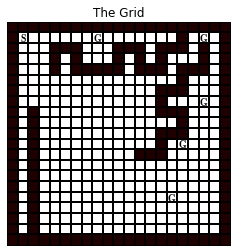

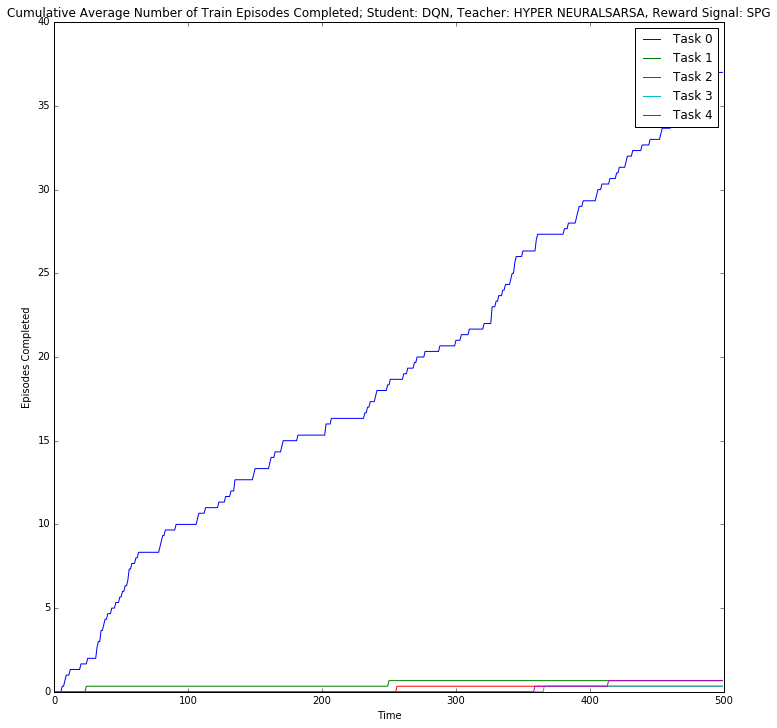

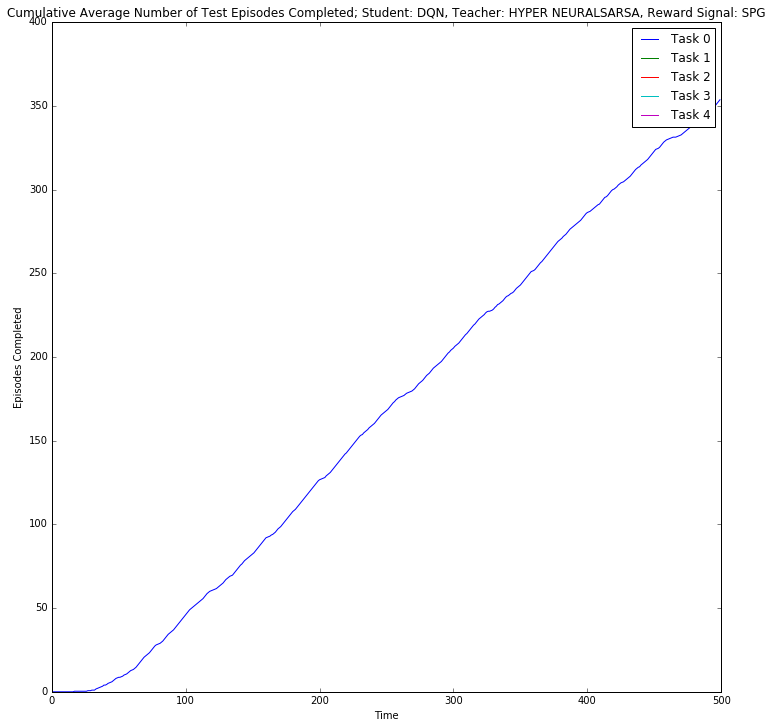

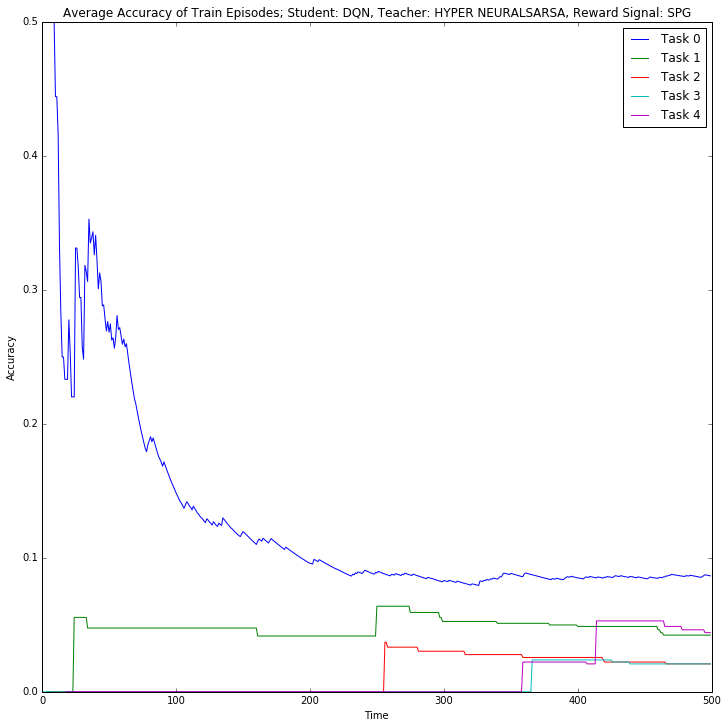

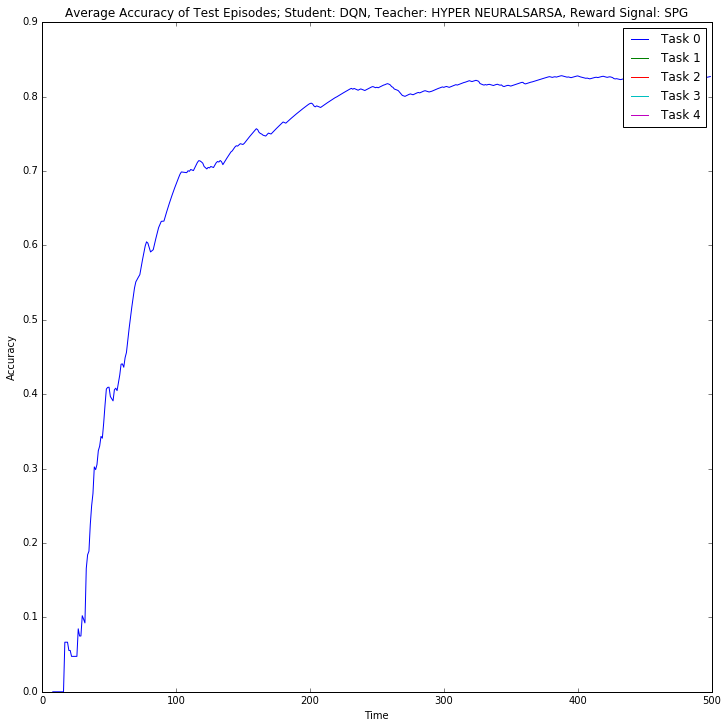

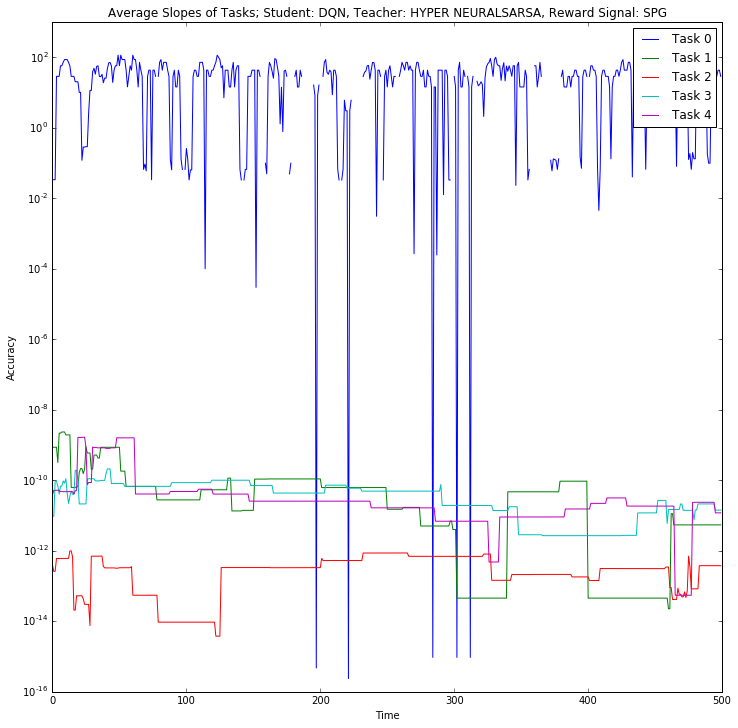

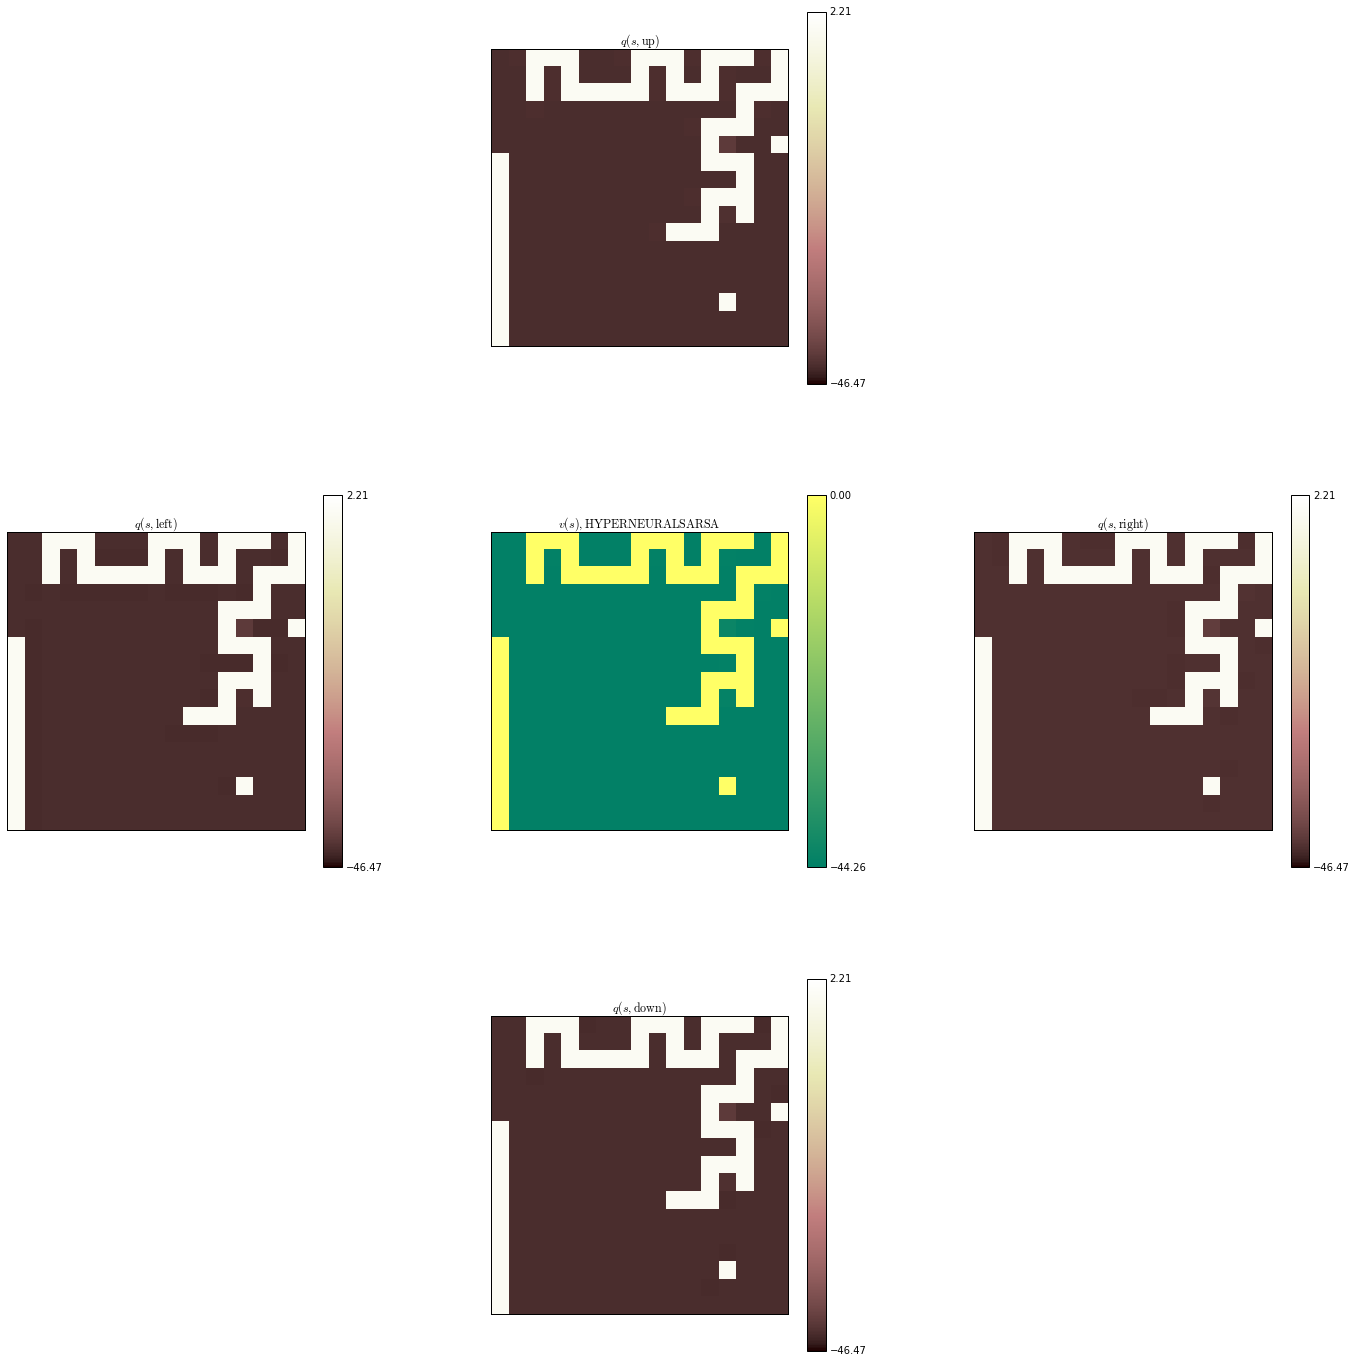

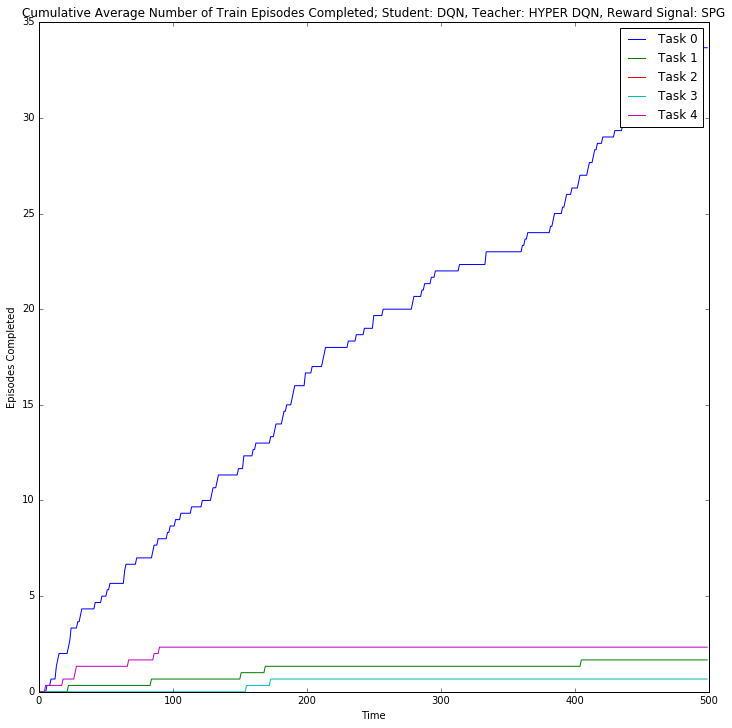

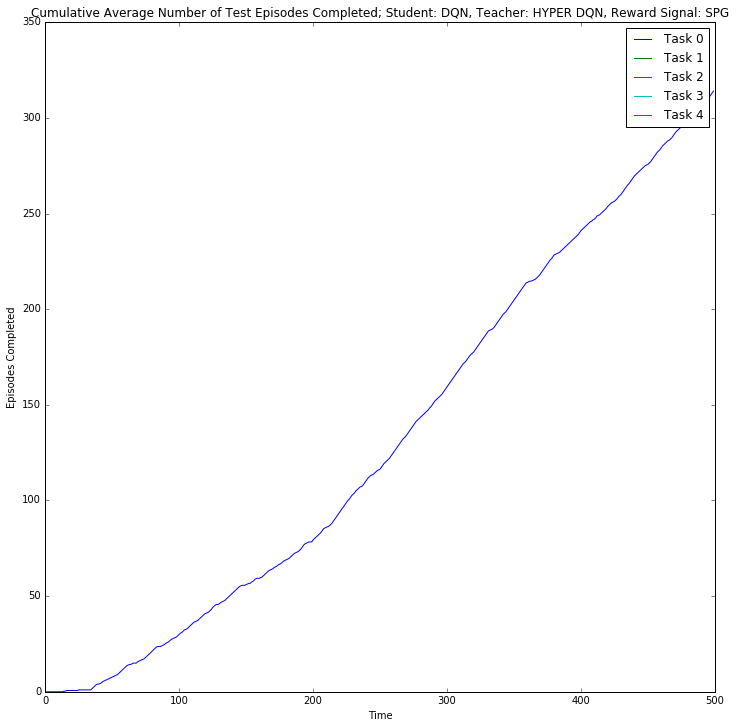

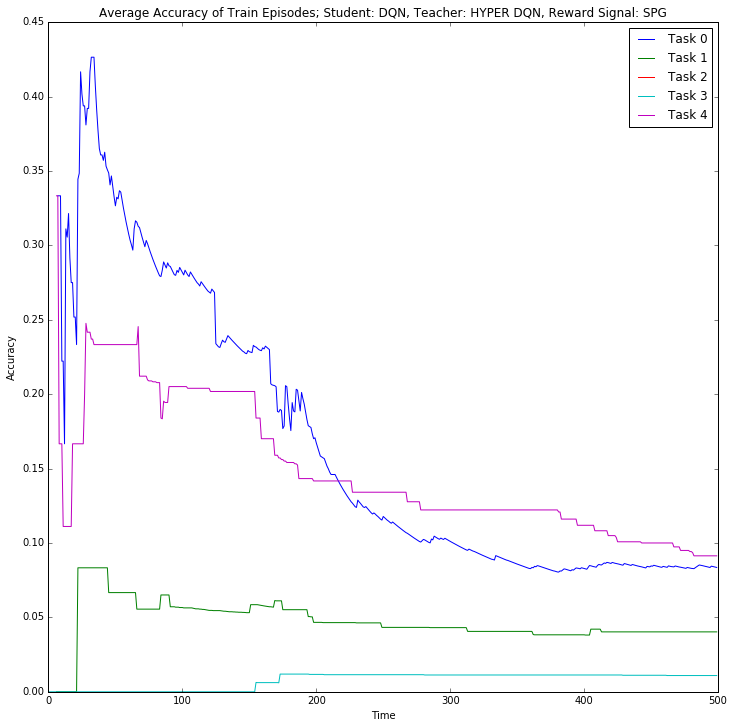

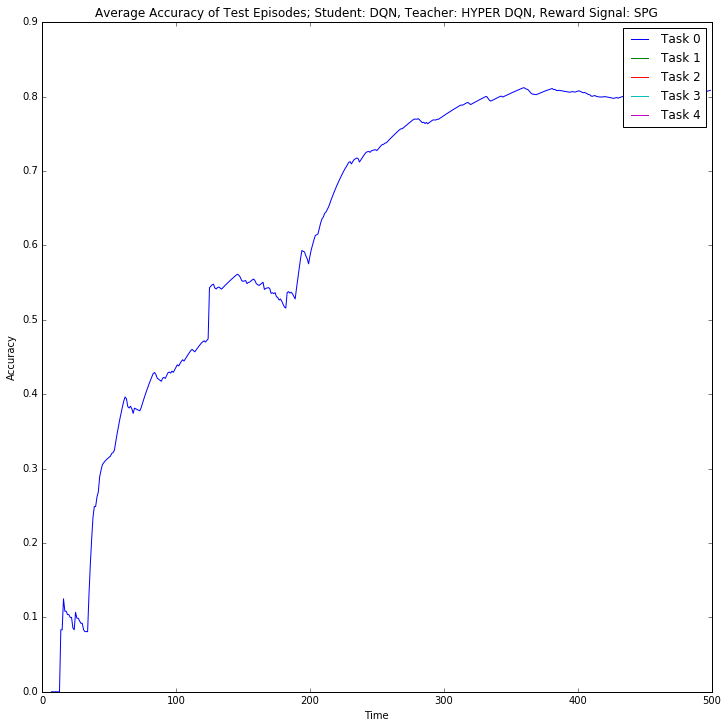

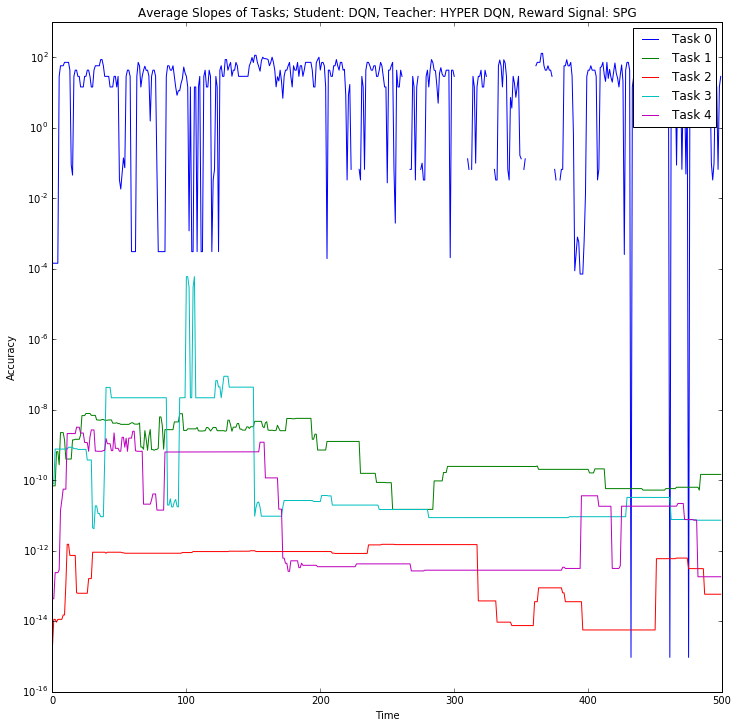

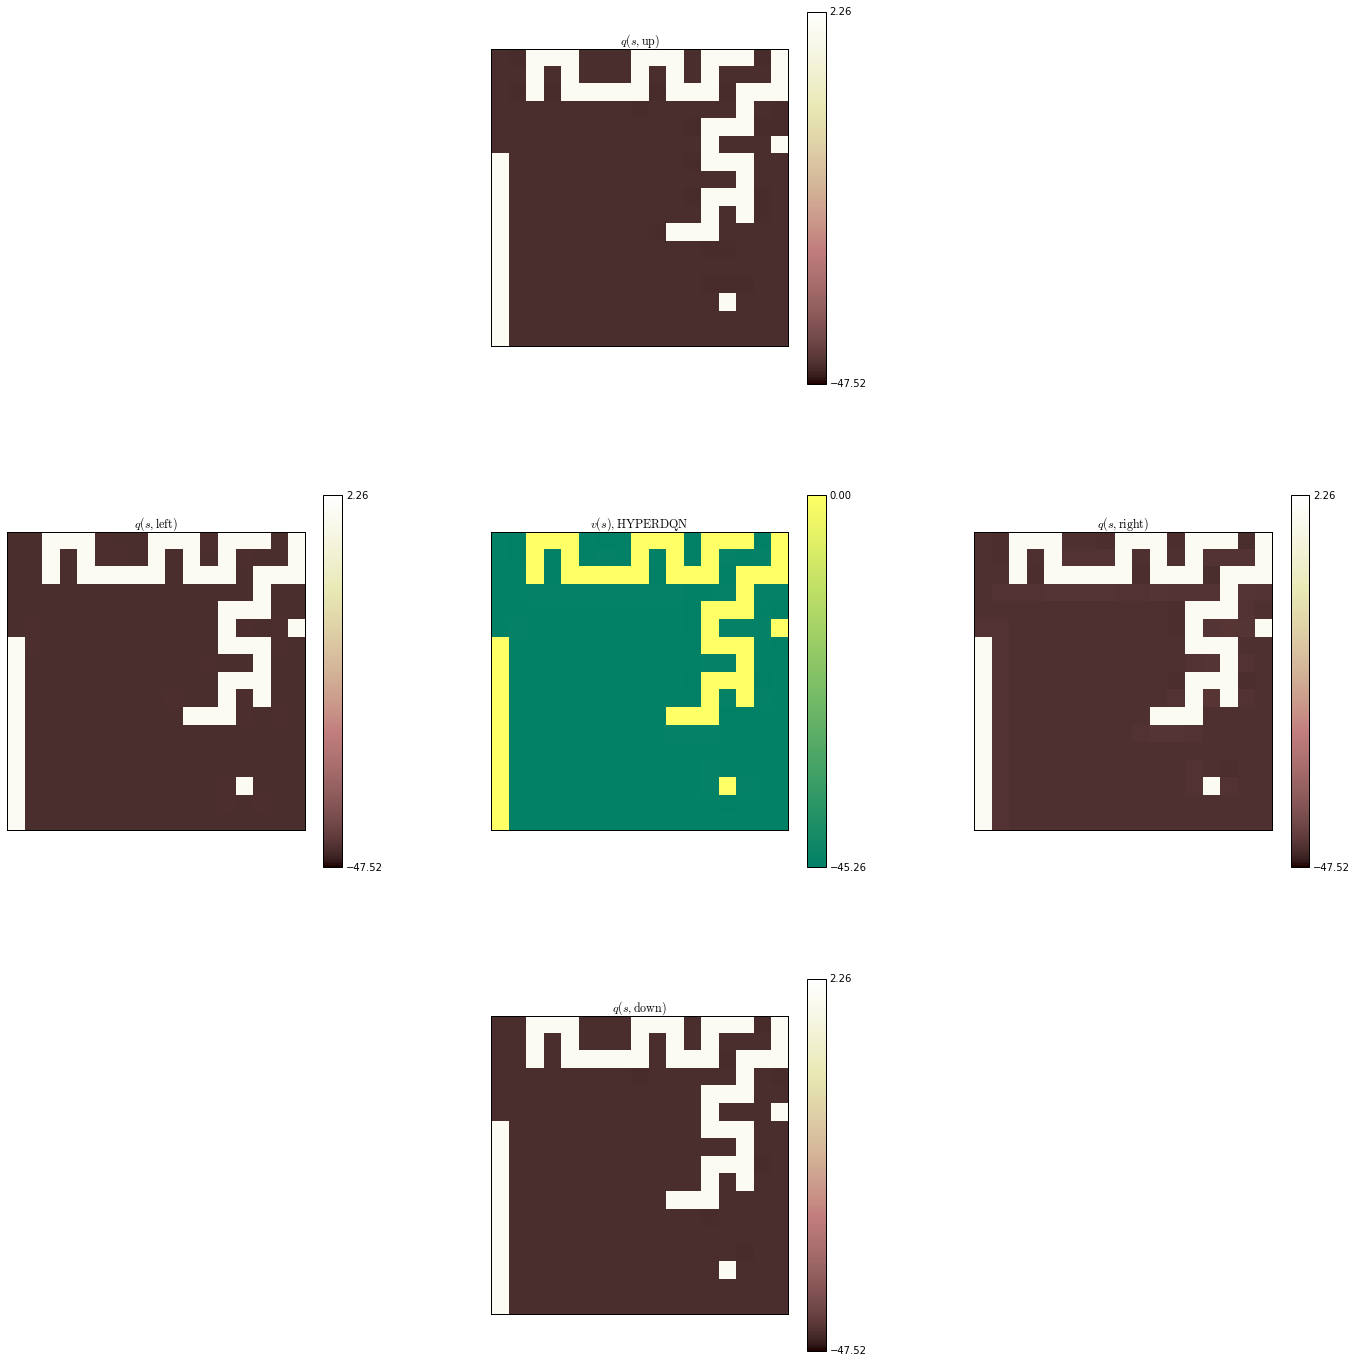

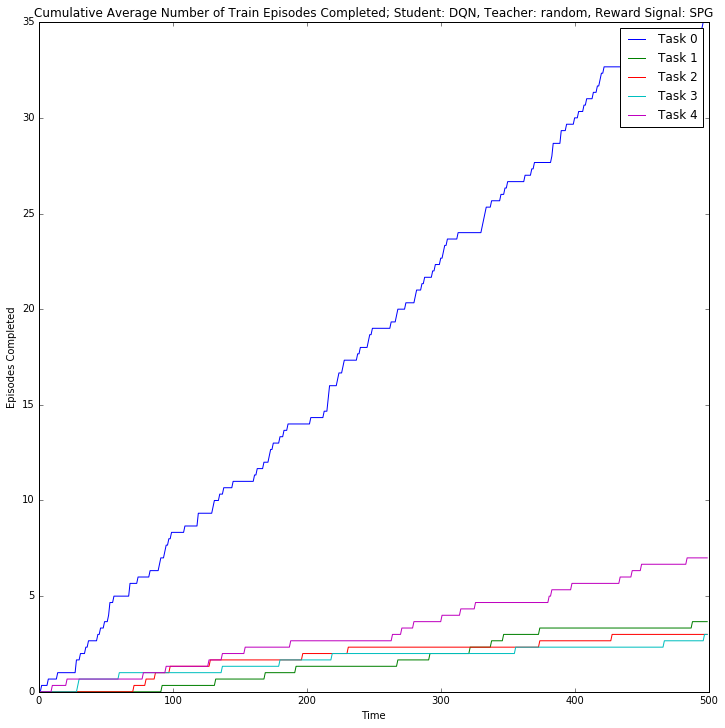

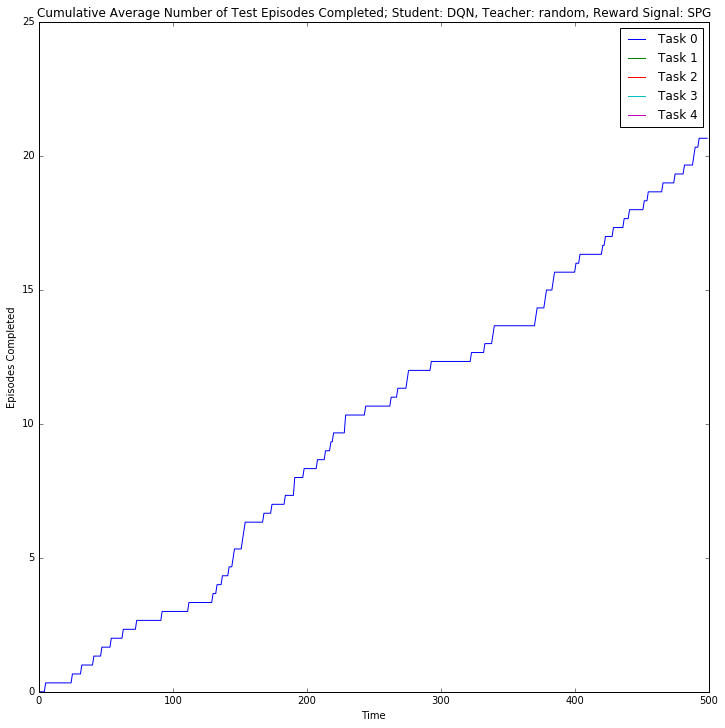

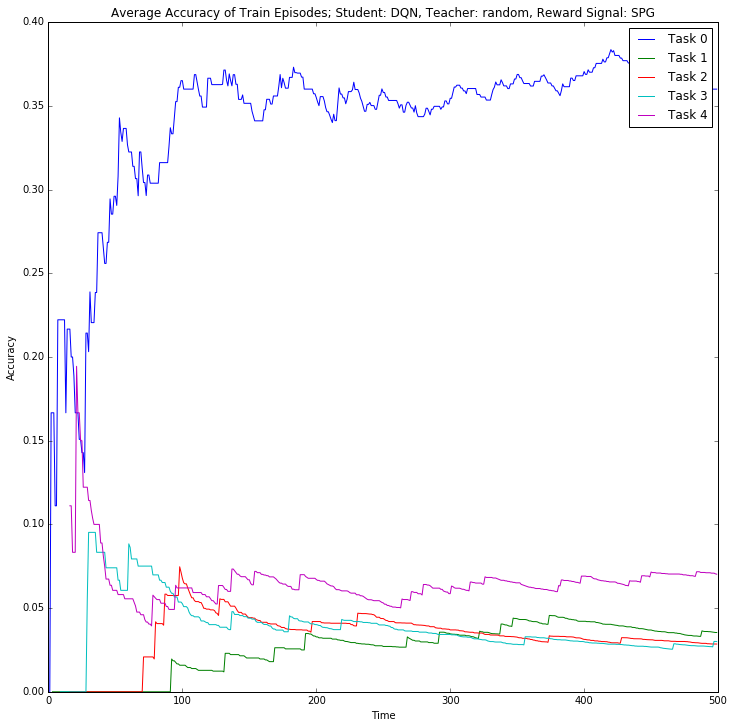

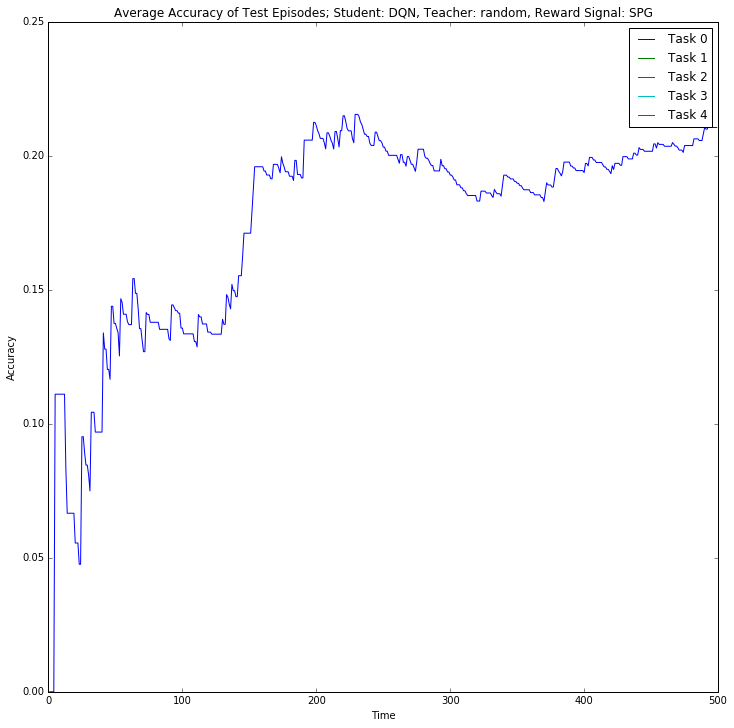

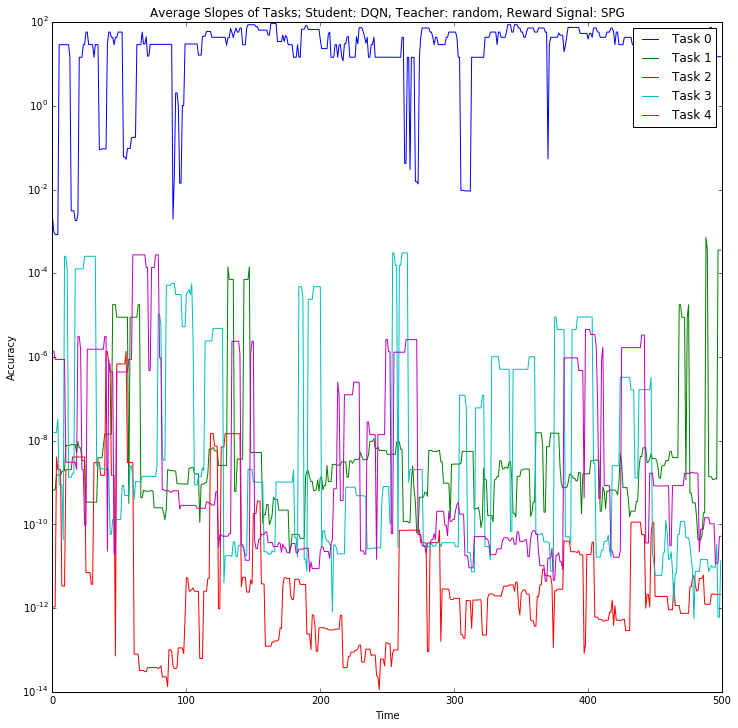

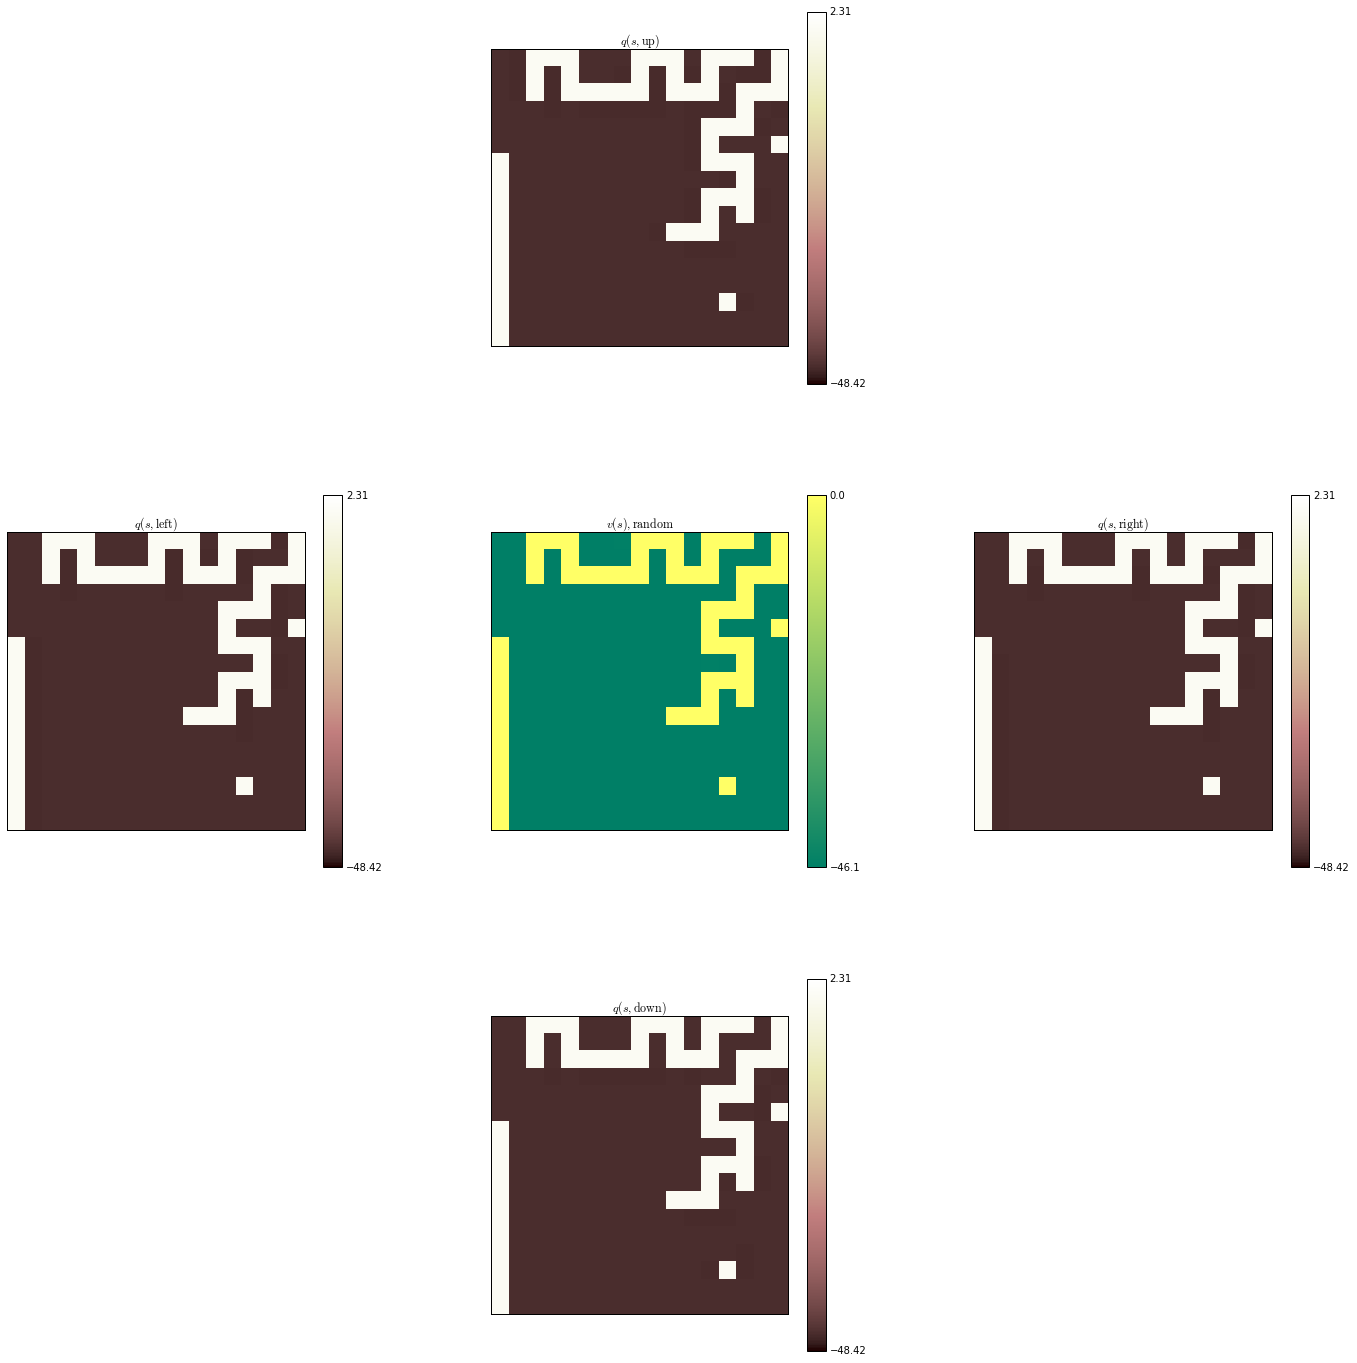

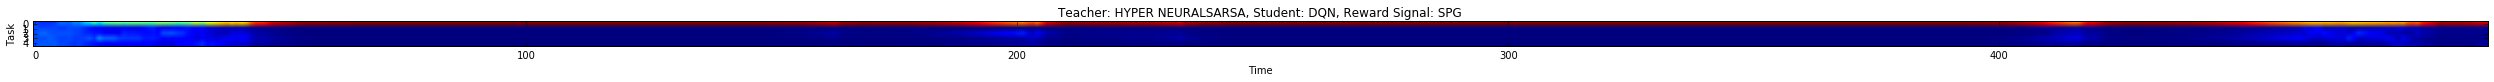

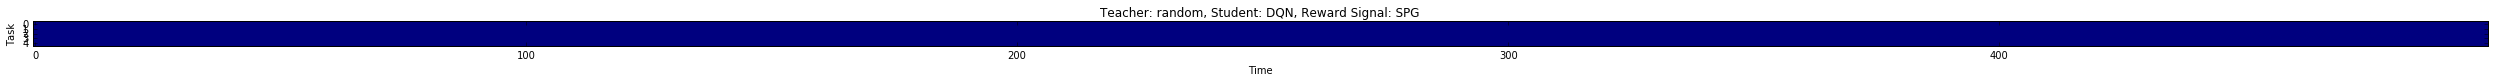

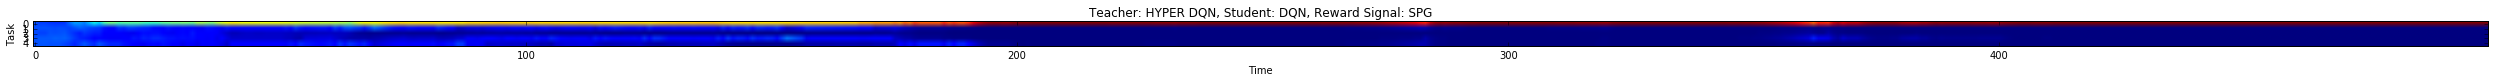

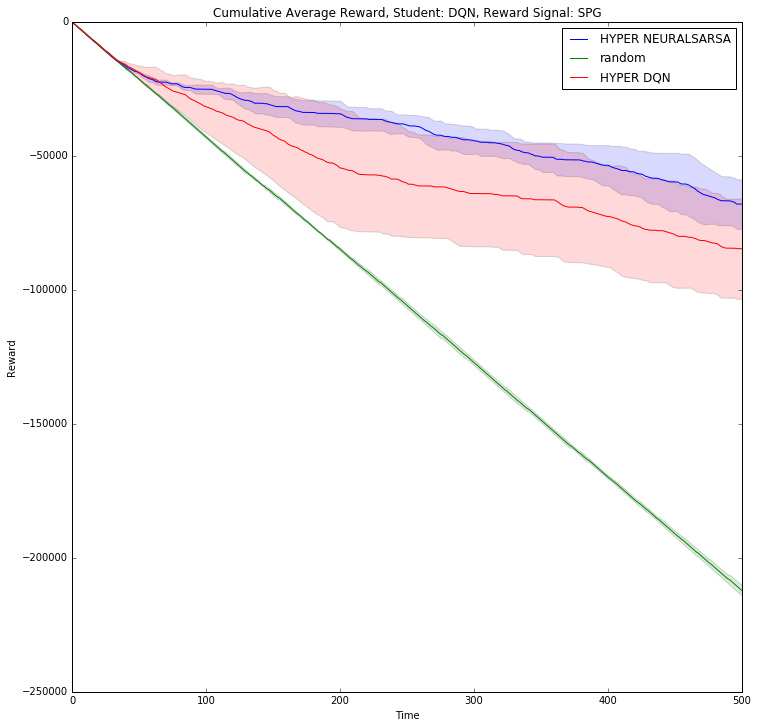

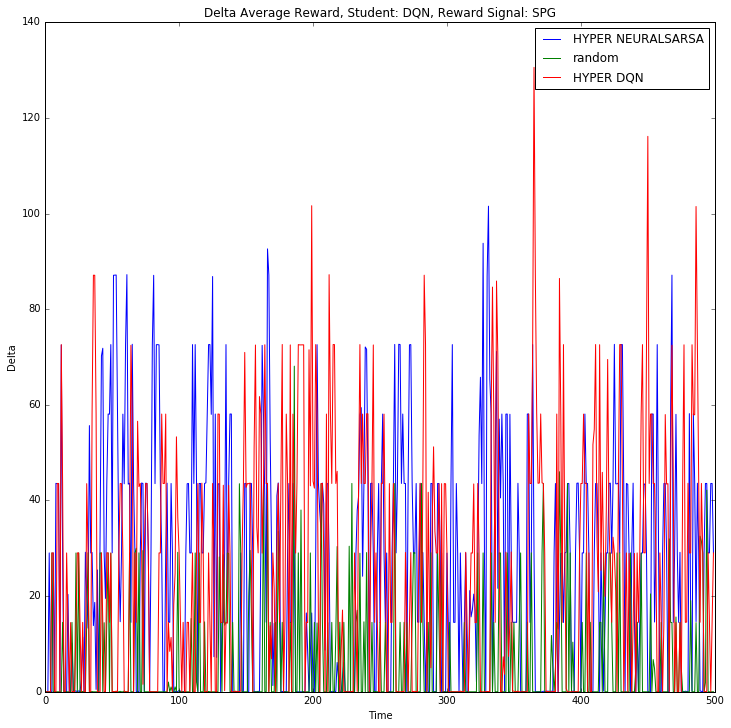

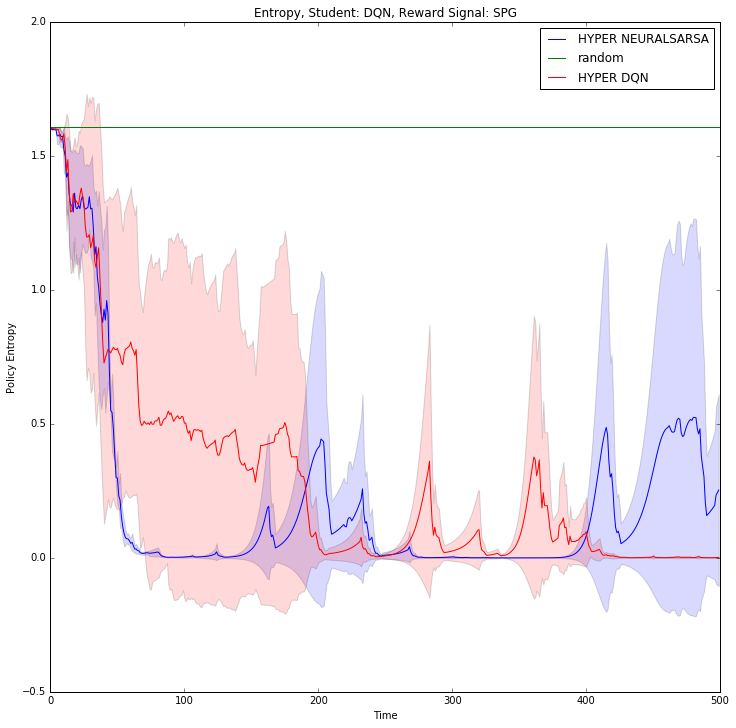

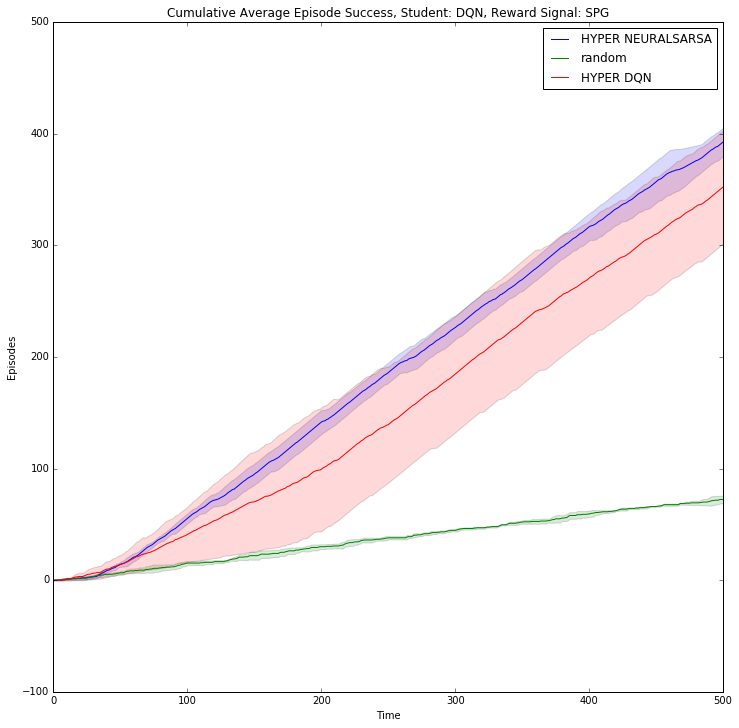

In [216]:
step_size_controller = 0.01
step_size_driver = 0.01

# goal_loc has format (row, col)

for task in tasks:
    task.plot_grid()
    
# Intrinsically Motivated Curriculum Learning
number_of_arms_tasks = len(tasks[0]._goal_loc)


agents = [
    NEURAL_CONTROLLER_DRIVER(number_of_arms_tasks*FIFO_buffer_scores_size,
                              (2*vision_size + 1)**2,
                              hidden_units_controller_net,
                              hidden_units_driver_net,
                              number_of_arms_tasks,
                              4,
                              np.zeros((1,number_of_arms_tasks*FIFO_buffer_scores_size)),
                              tasks[0].get_obs(),
                              'NEURALSARSA',
                              'DQN',
                              num_offline_updates_controller=0, 
                              num_offline_updates_driver=20,
                              step_size_controller=step_size_controller,
                              step_size_driver=step_size_driver),
  NEURAL_CONTROLLER_DRIVER(number_of_arms_tasks*FIFO_buffer_scores_size,
                              (2*vision_size + 1)**2,
                              hidden_units_controller_net,
                              hidden_units_driver_net,
                              number_of_arms_tasks,
                              4,
                              np.zeros((1,number_of_arms_tasks*FIFO_buffer_scores_size)),
                              tasks[0].get_obs(),
                              'DQN',
                              'DQN',
                              num_offline_updates_controller=0, 
                              num_offline_updates_driver=20,
                              step_size_controller=step_size_controller,
                              step_size_driver=step_size_driver),
#   NEURAL_CONTROLLER_DRIVER(number_of_arms_tasks*FIFO_buffer_scores_size,
#                               (2*vision_size + 1)**2,
#                               hidden_units_controller_net,
#                               hidden_units_driver_net,
#                               number_of_arms_tasks,
#                               4,
#                               np.zeros((1,number_of_arms_tasks*FIFO_buffer_scores_size)),
#                               tasks[0].get_obs(),
#                               'DQN',
#                               'NEURALSARSA',
#                               num_offline_updates_controller=25, 
#                               num_offline_updates_driver=25,
#                               step_size_controller=step_size_controller,
#                               step_size_driver=step_size_driver),
#     NEURAL_CONTROLLER_DRIVER(number_of_arms_tasks*FIFO_buffer_scores_size,
#                               (2*vision_size + 1)**2,
#                               hidden_units_controller_net,
#                               hidden_units_driver_net,
#                               number_of_arms_tasks,
#                               4,
#                               np.zeros((1,number_of_arms_tasks*FIFO_buffer_scores_size)),
#                               tasks[0].get_obs(),
#                               'NEURALSARSA',
#                               'NEURALSARSA',
#                               num_offline_updates_controller=25, 
#                               num_offline_updates_driver=25,
#                               step_size_controller=step_size_controller,
#                               step_size_driver=step_size_driver),
    Random(number_of_arms_tasks),
]


for reward_signal in reward_signals:
  train_task_agents(agents,
                    number_of_arms_tasks,
                    number_of_steps_of_selecting_tasks, 
                    tasks,
                    reward_signal,
                    reps,
                    vision_size,
                    tabular_grid,
                    'DQN',
                    hidden_units_driver_net)
        
    
    
    
    